In [2]:
import numpy as np
         
from matplotlib import pyplot as plt

import csb
import pandas as pd 
from Bio import SeqIO
import pandas as pd
from colour import Color
import pickle

import h5py
import dendropy
from Bio import AlignIO , SeqIO



In [5]:
tree = dendropy.Tree.get(
    path='./lanford/ft_TBE.tree.txt',
    schema='newick')
print(dir(tree))
print(len(tree.leaf_nodes()))

['B1', 'N_bar', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_as_newick_string', '_assign_node_labels_from_taxon', '_bipartition_edge_map', '_clone_from', '_compile_immutable_bipartition_for_edge', '_compile_mutable_bipartition_for_edge', '_debug_check_tree', '_debug_tree_is_valid', '_del_taxon_namespace', '_del_taxon_set', '_format_and_write_to_stream', '_get_annotations', '_get_bipartition_edge_map', '_get_from', '_get_indented_form', '_get_is_rooted', '_get_is_rootedness_undefined', '_get_is_unrooted', '_get_label', '_get_seed_node', '_get_split_bitmask_edge_map', '_get_split_edges', '_get_taxon_namespace', '_get_taxon_set', '_has_annotations', '_is

In [ ]:
#find colum mutual info using compression distance
#find interprot and intraprot interactions

import itertools
import gzip
import multiprocessing as mp
import lzma

import time

lzma_filters = my_filters = [
    {
      "id": lzma.FILTER_LZMA2, 
      "preset": 9 | lzma.PRESET_EXTREME, 
      "dict_size":len(msa[:,0]) * 40, # a big enough dictionary, but not more than needed, saves memory
      "lc": 3,
      "lp": 0,
      "pb": 0, # assume ascii
      "mode": lzma.MODE_NORMAL,
      "nice_len": 273,
      "mf": lzma.MF_BT4
    }
]

def clen(s):
    return len( lzma.compress(s, format=lzma.FORMAT_RAW, filters= lzma_filters) )
    #return len(gzip.compress(s))

def compress_dist(pargs):
    i,j,s1,s2 = pargs
    strings = [s1.ravel() , s2.ravel() , np.stack([s1,s2]).ravel() ]
    ls1 , ls2 , ls1_2 = map(clen, strings)
    
    return  (i,j,(ls1_2 - min(ls1,ls2) )/ max( ls1,ls2 ) )


def str2binary(s,char):
    return np.array([ 1 if c == char else 0 for c in s ])

def byteStr2str(s):
    return b"".join(list(s)).decode()

def binaryH(s):
    H = 0 
    for c in set(s):
        p = np.sum(str2binary(s,c))/len(s)
        H+= p*np.log(p)
    return H
    
def binaryJointH(s1,s2):
    
    H = 0
    for c1 in set(s1+s2):
        for c2 in set(s1+s2):
            v1 = str2binary(s1,c1)
            v2 = str2binary(s2,c2)
            
            sumvec = np.sum(np.vstack([v1,v2]) , axis = 0)
            pvec = np.zeros()
            pvec[np.where( sumvec == 2)] =1
            p = np.sum(pvec)
            H+= p*np.log(p)
    return H

        

def MI_dist(pargs):
    #calculate explicit MI
    
    #Hx + Hy - HXY
    
    
    i,j,s1,s2 = pargs
    binaryH(s1) + binaryH(s2) - binaryJointH(s1,s2)
    strings = [s1.ravel() , s2.ravel() , np.stack([s1,s2]).ravel() ]
    
    ls1 , ls2 , ls1_2 = map(clen, strings)
    return  (i,j,(ls1_2 - min(ls1,ls2) )/ max( ls1,ls2 ) )

In [3]:
#use the dataframe with orf predictions for one genome
annotation = pd.read_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06.csv')
print(annotation)

    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0            3  testgeno  YP_009725299.1  29848  1945    2698   8532       1   
1           11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
2           13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
3           14  testgeno  YP_009725298.1  29848   638     784   2697       1   
4           16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
5           17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
6           18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
7           20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
8           21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
9           22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
10          24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
11          25  testgeno  YP_009724391.1

In [15]:

#select genomes
#model translated prots
print(annotation.prots)
#write out the proteomes
geno = 'hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06'

def write_fasta( genos , genodf , path='COVIDpoteomes.fasta'  ):
    with open( path + geno , 'w' ) as fastout:
        for geno in genos:
            sub = genodf[ genodf.genome.is_in( geno ) ]
            for i,r in sub.itterrows():
                fastout.write( '>'+ i + '\n'+ r.prot + '\n' )

def write_split_fasta( genodf , path= None  ):
    #make a folder and split up the fasta for use with hhblits
    paths = []
    for i,r in genodf.iterrows():
        name = r.sseqid + geno 
        #name = i.replace('>','').replace('/','_')
        with open( path + r.sseqid + '.fasta', 'w' ) as fastout:
            fastout.write( '>'+ r.sseqid + '\n'+ r.prots + '\n' )
        paths.append(path + r.sseqid +'.fasta')
    return paths

paths = write_split_fasta( annotation , path = './gisaid/' )
print(paths)

0     APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...
1     SSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLP...
2     FKRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNC...
3     AYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKR...
4     AVGACVLCNSQTSLRCGACIRRPFLCCKCCYDHVISTSHKLVLSVN...
5     AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...
6     KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...
7     SLENVAFNVVNKGHFDGQQGEVPVSIINNTVYTKVDGVDVELFENK...
8     MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...
9     SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
10    SSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAK...
11    MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
12    SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...
13    MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
14    AIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAK...
15    AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLC...
16    MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...
17    NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVL

In [16]:
import subprocess
import shlex

def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [17]:
import glob
prots = paths
print(prots)

['./gisaid/YP_009725299.1.fasta', './gisaid/YP_009724390.1.fasta', './gisaid/YP_009725307.1.fasta', './gisaid/YP_009725298.1.fasta', './gisaid/YP_009725308.1.fasta', './gisaid/YP_009725309.1.fasta', './gisaid/YP_009725300.1.fasta', './gisaid/YP_009725310.1.fasta', './gisaid/YP_009724397.2.fasta', './gisaid/YP_009725301.1.fasta', './gisaid/YP_009725311.1.fasta', './gisaid/YP_009724391.1.fasta', './gisaid/YP_009725302.1.fasta', './gisaid/YP_009724393.1.fasta', './gisaid/YP_009725304.1.fasta', './gisaid/YP_009725306.1.fasta', './gisaid/YP_009724396.1.fasta', './gisaid/YP_009725305.1.fasta', './gisaid/YP_009724395.1.fasta', './gisaid/YP_009724394.1.fasta', './gisaid/YP_009725303.1.fasta', './gisaid/YP_009724392.1.fasta', './gisaid/YP_009725255.1.fasta', './gisaid/YP_009725318.1.fasta']


In [18]:
#run hhblits
results = {}
for prot in prots:    
    p, outfiles = runHHblits( prot , prot+'.hhr' , 'hhblits', outdir = './' , db ='/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70' , ohhm = True,  iterations = 1 , ncores = 8 , )
    results[prot]=outfiles

['./gisaid/YP_009725299.1.fasta', './gisaid/YP_009725299.1.fasta.hhr', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./gisaid/YP_009725299.1.fasta -o ././gisaid/YP_009725299.1.fasta.hhr.hhr -n 1 -B 2000 -Z 2000  -cons  -Oa3m ././gisaid/YP_009725299.1.fasta.hhr.a3m
['./gisaid/YP_009724390.1.fasta', './gisaid/YP_009724390.1.fasta.hhr', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./gisaid/YP_009724390.1.fasta -o ././gisaid/YP_009724390.1.fasta.hhr.hhr -n 1 -B 2000 -Z 2000  -cons  -Oa3m ././gisaid/YP_009724390.1.fasta.hhr.a3m
['./gisaid/YP_009725307.1.fasta', './gisaid/YP_009725307.1.fasta.hhr', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./gisaid/YP_009725307.1.fasta -o ././gisaid/YP_009725307.1.fas

In [20]:
#parse results
from csb.bio.io.hhpred import HHOutputParser
predDfs  = {}
topk = 3
models = []
predictions = glob.glob( './gisaid/*.hhr')
for pred in predictions:
    results = HHOutputParser(alignments=False).parse_file(pred)
    newhits = {}
    hitlist=[]
    for hit in results:
        hitlist.append(hit.id)
        newhits.update( {  hit.id : { 'prob':hit.probability, 'len' : hit.length , 'score': hit.score   , 'start':hit.start , 'stop':hit.end }}  )

    hhdf = pd.DataFrame.from_dict(newhits, orient = 'index')
    hhdf['model'] = hhdf.index.map(lambda x : x.split('_')[0])
    hhdf['chain'] = hhdf.index.map(lambda x : x.split('_')[1])
    print(hhdf.head())
    predDfs[pred] = hhdf
    models+=list(hhdf.model)[0:topk]
print(models)
    

         prob  len   score  start  stop model chain
6JYT_B  1.000  599  1012.0      3   601  6JYT     B
5WWP_B  1.000  594   946.4      3   596  5WWP     B
6I59_A  0.999  421   227.2    259   679  6I59     A
5MZN_A  0.999  421   226.1    259   679  5MZN     A
4B3F_X  0.998  407   208.1    205   611  4B3F     X
         prob  len  score  start  stop model chain
3GZF_A  0.999   91  204.6      5    95  3GZF     A
3GZF_D  0.999   91  204.6      5    95  3GZF     D
3VCB_B  0.999   93  202.3      1    93  3VCB     B
3VC8_A  0.999   93  202.2      1    93  3VC8     A
2K9J_B  0.394   26   24.3     16    41  2K9J     B
         prob  len  score  start  stop model chain
5X29_D  0.996   64  114.8     18    81  5X29     D
2MM4_A  0.994   58   97.0      1    58  2MM4     A
2NA9_A  0.292   13   20.5     22    34  2NA9     A
5Z1L_P  0.192   29   21.8      6    34  5Z1L     P
3S3B_B  0.184   17   20.0     34    50  3S3B     B
         prob  len  score  start  stop model chain
5YNM_A  1.000  297  350.2

In [ ]:
from skbio import TabularMSA, Protein
from Bio.Alphabet.IUPAC import protein as alpha
alpha = list(alpha.letters)+['-'] 
print(alpha)


In [21]:
#now we have some long high quality hits to some chains
#get templates
import wget
import glob

dl_url = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
for m in models:
    print(m)
    structfile = './templates/'+m.upper()+'.pdb'
    structs[m]= structfile
    if structfile not in already:
        wget.download(url = dl_url + m +'.pdb' , out =structfile)

6JYT
5WWP
6I59
3GZF
3GZF
3VCB
5X29
2MM4
2NA9
5YNM
5YNN
2XYQ
1UL7
4ORY
4ORX
1PON
5I0I
3AKB
3EE7
1QZ8
1UW7
4HYT
3WGU
5AVT
5J3N
6N2L
4I2Z
1YO4
1XAK
3BYR
4UD1
1SSK
2OFZ
5C5O
5N19
2Z3E
2KYS
2AHM
5F22
3DIN
1JJO
1JJO
1O57
5XTD
5AZD
4M0W
4MM3
4RNA
5YNM
5YNF
5C8S
2C6A
2CR8
4XXB
5NFY
5C8S
5C8T
2H85
4S1T
4RS4
6ACC
6CS2
5I08
6NUR
4IKA
1XR5
2AHM
3UB0
3UB0
1QF8
3EED
1JWH


In [22]:
from Bio.PDB import *
#find ca string for each strucutre
#make sure you grab the right chain
from Bio import Alphabet
parser = PDBParser()
from Bio.SeqUtils import seq1
letter3 = Alphabet.ThreeLetterProtein.letters
converter = { l.upper(): seq1(l) for l in letter3} 
print(converter)

{'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W', 'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}


In [23]:
models = {}
ali_input = {}
builder = Polypeptide.PPBuilder()
#slice structures in hhr

io=PDBIO()
sliceprots = False


class resselect(Select):
    def __init__(self, reslist):
        self.reslist=reslist
    
    def accept_residue(self ,residue ):
        if residue in self.reslist:
            return 1
        else:
            return 0      
for df in predDfs:
    print(predDfs[df])
    count = 0
    for i,row in predDfs[df].iterrows():
        if count < topk:
            count+=1
            code = row.model
            if code in structs:
                print(code)

                structure = parser.get_structure(code,structs[code])
                io.set_structure(structure)

                for chain in structure.get_chains():
                    if chain.id == row.chain:
                        #trim the structures to hhblits detected regions
                        if sliceprots == True:
                            #Dice.extract(structure=structure , chain_id=chain.id , start=row.start-1, end=row.stop , filename='./modellercif/'+row.model+'.pdb' )
                            #sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                            #subchains = [ c for c in structure.get_chains()]
                            peptides  = [p for p in  builder.build_peptides(chain)]
                            peptidelen  = [len(p) for p in  builder.build_peptides(chain)]
                            print(peptidelen)

                        else:
                            #Dice.extract(structure=structure , chain_id=chain.id , start=0, end=len(chain), filename='./modellercif/'+row.model+'.pdb' )

                            #sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                            #sub_structure = structure
                            peptides  = [p for p in  builder.build_peptides(chain)]
                            peptidelen  = [len(p) for p in  builder.build_peptides(chain)]
                            print(peptidelen)
                            #pp = peptides[0]

                        for i,pp in enumerate( peptides):
                            #break all subchains into files
                            if peptidelen[i] > 75:
                                io.save('./modellercif/'+row.model+'_'+str(i) +'.pdb', resselect(pp))
                                seq = str(pp.get_sequence())
                                print(seq)
                                models[row.model+'_'+str(i)]={'mdl': './modellercif/'+row.model+'_'+str(i) +'.pdb' , 'chain':chain.id }
                            #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  } 
                        #mdl = model(env, file='./modellercif/'+row.model+'.pdb', model_segment=('FIRST:'+chain.id, 'LAST:'+chain.id))
                        #chains = mdl.make_chains(file='./modellercif/'+row.model+'.pdb')

                        #for i,pp in enumerate(peptides):
                        #    if i > 0:
                        #        seq+='-'
                        #    seq += str(pp.get_sequence())
                        #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  }     
                        # grab all sequences from the query input

print('DONE')

         prob  len   score  start  stop model chain
6JYT_B  1.000  599  1012.0      3   601  6JYT     B
5WWP_B  1.000  594   946.4      3   596  5WWP     B
6I59_A  0.999  421   227.2    259   679  6I59     A
5MZN_A  0.999  421   226.1    259   679  5MZN     A
4B3F_X  0.998  407   208.1    205   611  4B3F     X
...       ...  ...     ...    ...   ...   ...   ...
2H5E_A  0.210   18    31.8     17    34  2H5E     A
3SFS_W  0.210   18    31.8     17    34  3SFS     W
2QTF_A  0.209   18    30.8    183   200  2QTF     A
5NO3_Z  0.207   23    29.9    175   197  5NO3     Z
1JR3_D  0.201   27    28.4     16    42  1JR3     D

[1649 rows x 7 columns]
6JYT
[69, 164, 40, 54, 48, 50, 6, 37, 101, 20]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10163.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10166.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10169.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10238.
  PDBConstructionWarning)


SYYCKSHKPPISFPLCANGQVFGLYKNTCVGSDNVTDFNAIATCDWTNAGDYILANTCTERLKLFAAETLKATEETFKLSYGIATVREVLSDRELHLSWEVGKPRPPLNRNYVFTGYRVTKNSKVQIGEYTFEKGDYGDAVVYRGTTTYKLNVGDYFVLTSHTV
FYKGVITHDVSSAINRPQIGVVREFLTRNPAWRKAVFISPYNSQNAVASKILGLPTQTVDSSQGSEYDYVIFTQTTETAHSCNVNRFNVAITRAKIGILCI
5WWP


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9456.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning)


[186, 405]
PAVGSCVVCHSQTSLRCGTCIRRPFLCCKCCYDHVIATPHKMVLSVSPYVCNAPGCGVSDVTKLYLGGMSYFCVDHRPVCSFPLCANGLVFGLYKNMCTGSPSIVEFNRLATCDWTESGDYTLANTTTEPLKLFAAETLRATEEASKQSYAIATIKEIVGERQLLLVWEAGKSKPPLNRNYVFTGY
KVQLGEYIFERIDYSDAVSYKSSTTYKLTVGDIFVLTSHSVATLTAPTIVNQERYVKITGLYPTITVPEEFASHVANFQKSGYSKYVTVQGPPGTGKSHFAIGLAIYYPTARVVYTACSHAAVDALCEKAFKYLNIAKCSRIIPAKARVECYDRFKVNETNSQYLFSTINALPETSADILVVDEVSMCTNYDLSIINARIKAKHIVYVGDPAQLPAPRTLLTRGTLEPENFNSVTRLMCNLGPDIFLSMCYRCPKEIVSTVSALVYNNKLLAKKELSGQCFKILYKGNVTHDASSAINRPQLTFVKNFITANPAWSKAVFISPYNSQNAVSRSMLGLTTQTVDSSQGSEYQYVIFCQTADTAHANNINRFNVAITRAQKGILCVMTSQALFESLEFTELSFTNYK
6I59
[286, 75, 162, 85, 74]
ELAKQELEHMRKRLNVDMNPLYEIILQWDYTRNSEYPDDEPIGNYSDVKDFFNSPADYQKVMKPLLLLESWQGLCSSRDREDYKPFSIIVGNRTAVSDFYDVYASVAKQVIQDCGISESDLIVMAYLPDFRPDKRLSSDDFKKAQHTCLAKVRTLKNTKGGNVDVTLRIHRNHSFSKFLTLRSEIYCVKVMQMTTIEREYSTLEGLEYYDLVGQILQAKPSPPVNVDAAEIETVKKSYKLNTSQAEAIVNSVSKEGFSLIQGPPGTGKTKTILGIIGYFLSTKNAS
NYRNRDLDRRNAQAHILAVSDIICSTLSGSAHDVLATMGIKFDTVIIDEACQCTELSSIIPLRYGGKRCIMVGDPNQLPPT

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4357.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4362.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4367.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4374.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4379.
  PDBC

[91]
LFEGDKFVGSFESAAMGTFVIDMRSYETLVNSTSLDRIKSYANSFNKYKYYTGSMGEADYRMACYAHLGKALMDYSVSRNDKLYTPPTVSV
3VCB
[89]
STFEEMALTTFMITKESYSKLKNSVSDVAFNRYLSLYNKYRYFSGKMDTAAYREAACSQLAKAMETFNHNNGNDVLYQPPTASVTTSFL
         prob  len  score  start  stop model chain
5X29_D  0.996   64  114.8     18    81  5X29     D
2MM4_A  0.994   58   97.0      1    58  2MM4     A
2NA9_A  0.292   13   20.5     22    34  2NA9     A
5Z1L_P  0.192   29   21.8      6    34  5Z1L     P
3S3B_B  0.184   17   20.0     34    50  3S3B     B
5O4U_B  0.159   21   20.9      9    29  5O4U     B
3S8G_B  0.106   14   18.6     37    50  3S8G     B
5T42_A  0.096    8   17.4     23    30  5T42     A
6JNF_E  0.095   19   18.4     33    51  6JNF     E
6UCU_L  0.095   27   18.4     23    49  6UCU     L
5X29
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
2MM4
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
2NA9
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[4

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6783.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6939.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6943.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7359.
  PDBConstructionWarning)


GSNESKALFFTYLCNLINNNLALGGSVAIKITEHSWSVELYELMGKFAWWTVFCTNANASSSEGFLLGINYLGTIKENIDGGAMHANYIFWRNSTPMNLSTYSLFDLSKFQLKLKGTPVLQLKESQINELVISLLSQGKLLIRDND
5YNN
[295]
ASADWKPGHAMPSLFKVQNVNLERCELANYKQSIPMPRGVHMNIAKYMQLCQYLNTCTLAVPANMRVIHFGAGSDKGIAPGTSVLRQWLPTDAIIIDNDLNEFVSDADITLFGDCVTVRVGQQVDLVISDMYDPTTKNVTGSNESKALFFTYLCNLINNNLALGGSVAIKITEHSWSVELYELMGKFAWWTVFCTNANASSSEGFLLGINYLGTIKENIDGGAMHANYIFWRNSTPMNLSTYSLFDLSKFQLKLKGTPVLQLKESQINELVISLLSQGKLLIRDNDTLSVSTDVL
2XYQ


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6849.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7007.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7011.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7339.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3843.
  PDBC

[135, 152]
ASQAWQPGVAMPNLYKMQRMLLEKCDLQNYGENAVIPKGIMMNVAKYTQLCQYLNTLTLAVPYNMRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATVHTANKWDLIISDMYDPR
VTKENDSKEGFFTYLCGFIKQKLALGGSIAVKITEHSWNADLYKLMGHFSWWTAFVTNVNASSSEAFLIGANYLGKPKEQIDGYTMHANYIFWRNTNPIQLSSYSLFDMSKFPLKLRGTAVMSLKENQINDMIYSLLEKGRLIIRENNRVVV
         prob  len  score  start  stop model chain
1UL7_A  0.455   41   23.3     10    50  1UL7     A
4ORY_F  0.334   20   22.7     32    51  4ORY     F
4ORX_A  0.295   20   22.3     31    50  4ORX     A
6FG8_B  0.291   31   22.0     11    41  6FG8     B
4OS3_A  0.262   19   21.8     31    49  4OS3     A
1IV2_F  0.140   26   22.8     84   109  1IV2     F
1IV3_A  0.140   26   22.8     84   109  1IV3     A
4PSQ_A  0.132   45   20.9     17    61  4PSQ     A
1IV1_B  0.128   24   22.5     86   109  1IV1     B
3OSE_A  0.119   43   19.7     26    68  3OSE     A
1UL7
[102]
GSSGSSGRFTWSMKTTSSMDPSDMMREIRKVLGANNCDYEQRERFLLFCVHGDGHAENLVQWEMEVCKLPRLSLNGVRFKRISGTSIAFKNIASKIANELKL
[102]
GSSGSSGRFTWSMKTTSSM

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 21181.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 21257.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21333.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 21358.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 21365.
 

[167]
APEAQVSVQPNFQQDKFLGRWFSAGLASNSSWLREKAAALSMAKSVVAPATDGGLNLTSTFLRKNQCETRTMLLQPAGSLGSYSYRSPHWGSTYSVSVVETDYDQYALLYSQGSKGPGEDFRMATLYSRTQTPRAELKEKFTAFCKAQGFTEDTIVFLPQTDKCMTE
4ORX
[159]
SVQPNFQQDKFLGRWFSAGLASNSSWLREKAAALSMAKSVVAPATDGGLNLTSTFLRKNQCETRTMLLQPAGSLGSYSYRSPHWGSTYSVSVVETDYDQYALLYSQGSKGPGEDFRMATLYSRTQTPRAELKEKFTAFCKAQGFTEDTIVFLPQTDKCM
         prob  len  score  start  stop model chain
1PON_A  0.554   18   16.7     17    34  1PON     A
5I0I_G  0.445   19   16.6     13    31  5I0I     G
3AKB_A  0.222   20   20.7     16    35  3AKB     A
2SCP_A  0.285   19   22.0    106   124  2SCP     A
5VP3_A  0.279   19   22.7    138   156  5VP3     A
5XPD_A  0.266   18   27.0     79    96  5XPD     A
2CCM_B  0.210   18   21.1    121   138  2CCM     B
2KI0_A  0.215   12   22.4     13    24  2KI0     A
5BPJ_A  0.210   19   22.2    140   158  5BPJ     A
1UHH_A  0.210   18   21.2    121   138  1UHH     A
1UHK_B  0.210   18   21.2    121   138  1UHK     B
1UHI_A  0.210   18   21.2    121   138  1UH

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31634.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31738.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31822.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31827.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31832.
 

[43]
3AKB
[166]
EYERRIAARFTTFDQDGNGHIDRSDFSGAAKAMLAEFGVAARSDRGQALYGGAEALWQGLAGIADRDGDQRITREEFVTGAVKRLRDKPDRFAEMARPFLHAALGVADTDGDGAVTVADTARALTAFGVPEDLARQAAAALDTDGDGKVGETEIVPAFARYFTVPA
         prob  len  score  start  stop model chain
3EE7_D  1.000  112  245.7      1   112  3EE7     D
1QZ8_A  1.000  112  240.4      1   112  1QZ8     A
1UW7_A  1.000  112  245.4     31   142  1UW7     A
2J97_A  1.000  108  228.2      1   108  2J97     A
2J98_A  1.000  108  227.7      1   108  2J98     A
5C94_A  1.000  110  228.7      6   115  5C94     A
5YM6_B  1.000  108  228.2      1   108  5YM6     B
5HIZ_A  1.000  107  220.5      1   107  5HIZ     A
5YM8_B  1.000  100  212.1      2   101  5YM8     B
1QTN_B  0.446   44   22.2      5    48  1QTN     B
3EE7
[33, 79]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2283.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2298.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2303.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning)


GRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLESLAATVRLQLEH
1QZ8
[111]
ELSPVALRQMSCAAGTTQTACTDDNALAYYNNSKGGRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQ
1UW7
[122]
FLEVLFQGPNNELSPVALRQMSCAAGTTQTACTDDNALAYYNNSKGGRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQ
         prob  len  score  start  stop model chain
4HYT_D  0.834   28   30.9     34    61  4HYT     D
3WGU_B  0.834   28   30.9     34    61  3WGU     B
5AVT_B  0.816   28   30.6     36    63  5AVT     B
2ZXE_B  0.816   28   30.6     36    63  2ZXE     B
5AVR_B  0.816   28   30.6     36    63  5AVR     B
3KDP_D  0.783   28   29.1     17    44  3KDP     D
3B8E_B  0.681   26   21.3      8    33  3B8E     B
3B8E_D  0.681   26   21.3      8    33  3B8E     D
2KNC_B  0.535   16   20.5     25    40  2KNC     B
4RVY_X  0.458   28   20.1      4    31  4RVY     X
5B66_x  0.439   28   20.1      4    31  5B66     x
5V2C_x  0.396   28   19.7      5    32  5V2C     x


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 42735.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 43135.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 43295.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 43405.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 43549.
 

[287]
WNSEKKEFLGRTGGSWFKILLFYVIFYGCLAGIFIGTIQVMLLTISEFKPTYQDRVAPPGLTQIPQSQKTEISFRPNDPQSYESYVVSIVRFLEKYKDLAQKDDMIFEDCGNVPSELKERGEYNNERGERKVCRFRLEWLGNCSGLNDETYGYKDGKPCVIIKLNRVLGFKPKPPKNESLETYPVMKYNPYVLPVHCTGKRDEDKEKVGTMEYFGLGGYPGFPLQYYPYYGKLLQPKYLQPLMAVQFTNLTMDTEIRIECKAYGENIGYSEKDRFQGRFDVKIEVKS
3WGU


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 43618.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 43928.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 44024.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 44362.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 44430.
 

[303]
MARGKAKEEGSWKKFIWNSEKKEFLGRTGGSWFKILLFYVIFYGCLAGIFIGTIQVMLLTISEFKPTYQDRVAPPGLTQIPQSQKTEISFRPNDPQSYESYVVSIVRFLEKYKDLAQKDDMIFEDCGNVPSELKERGEYNNERGERKVCRFRLEWLGNCSGLNDETYGYKDGKPCVIIKLNRVLGFKPKPPKNESLETYPVMKYNPYVLPVHCTGKRDEDKEKVGTMEYFGLGGYPGFPLQYYPYYGKLLQPKYLQPLMAVQFTNLTMDTEIRIECKAYGENIGYSEKDRFQGRFDVKIEVKS
5AVT
[136, 49, 83]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11036.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11047.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11117.
  PDBConstructionWarning)


FLGRTGSSWFKIFLFYLIFYGCLAGIFIGTIQVLLLTLSDFEPKYQDRVAPPGLSHAPYAIKTEISFSISNPKSYESFVKSMHKLMDLYNESSQAGNSPFEDCSDTPADYIKRGDLDDSQGQKKACRFSRMWLKNC
REKIGSIEYFGLGGYAGFPLQYYPYYGKRLQKKYLQPLLAIQFTNLTQNMELRIECKVYGENIDYSEKDRFRGRFEVKIEVKS
         prob  len  score  start  stop model chain
5J3N_A  0.217   22   25.0    241   262  5J3N     A
6N2L_A  0.178   40   17.9      8    47  6N2L     A
4I2Z_A  0.163   29   24.6    297   325  4I2Z     A
4I2W_A  0.156   29   24.4    297   325  4I2W     A
4HS2_A  0.122   22   15.3     59    80  4HS2     A
5EUL_E  0.120   22   17.4     38    59  5EUL     E
4YF0_B  0.115   29   15.4     11    39  4YF0     B
5J0N_I  0.102   32   15.5      7    38  5J0N     I
5FBM_A  0.098   35   16.3      6    40  5FBM     A
5WTK_A  0.088   36   26.1   1347  1382  5WTK     A
5J3N
[65, 189, 131]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5566.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5684.
  PDBConstructionWarning)


VQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKDDGNILGHKLEYNYNEHLVYIMADKQKNGTKAIFQVHHNIEDGGVQLADHYQQNTPIGDGPVLLPDNHYLHTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYKEFEINLDYILGLIFEHNR
GEMIEEVKRLIRSSLGNRAKEGLVVDFIQQTNLDDLPDKASIIDAFFTFAQREQQREAEALIKEENLNEDAAKRYIRTSLKREYATENGTELNETLPKLSPLNPQYKTKKQAVFQKIVSFIEKFKGVGGKI
6N2L
[64, 24]
4I2Z
[50, 89, 15, 61, 4, 15, 22, 2, 5, 23, 22, 54, 14, 28, 20, 2, 7, 20, 30, 83, 103, 63, 71, 14, 11, 5, 40]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14670.
  PDBConstructionWarning)


ARLKRDDFEGAQSDCTKALEFDGADVKALFRRSLAREQLGNVGPAFQDAKEALRLSPNDKGIVEVLQRLVKANNDKIKQTTSLANKVTD
VISLAKTCKKFLLETEKYSVDIRRYACEGLSYLSLDADVKEWIVDDSLLLKALVLLAKKAGALCVYTLATIYANLSNAFEKPK
FAKHHVPETHPKDTEEYVEKRVRALVEEGAVPACVAVSKTESKNALELIARSLLAFAEYEDLRGRIIAEGGTVLCLRLTKEASGEGKIKAGHAIAKLGAKADP
         prob  len  score  start  stop model chain
1YO4_A  1.000   86  276.4      1    86  1YO4     A
1XAK_A  1.000   82  271.7      1    82  1XAK     A
3BYR_A  0.294   20   19.8     25    44  3BYR     A
3BYP_B  0.294   20   19.8     25    44  3BYP     B
1UTR_A  0.289   15   22.7      1    15  1UTR     A
3ZBI_U  0.214   16   20.5      1    16  3ZBI     U
6C70_A  0.213   26   24.5    345   370  6C70     A
2GE9_A  0.192   26   19.4     94   119  2GE9     A
3JAF_A  0.179   29   22.7    314   342  3JAF     A
4CG7_C  0.162   19   18.7      9    27  4CG7     C
1YO4
[87]
GPELYHYQECVRGTTVLLKEPCPSGTYEGNSPFHPLADNKFALTCTSTHFAFACADGTRHTYQLRARSVSPKLFIRQEEVQQELYSR
[87]
GPELYHYQECVRGTTVLLKEPCPSGTYEGNSPFHPLADNKFALTCTSTHFAFACADGT

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10833.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10838.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10867.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10896.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10910.
 

[133]
PKPRAAPNNTVSWYTGLTQHGKVPLTFPPGQGVPLNANSTPAQNAGYWRRQDRKINTGNGIKQLAPRWYFYYTGTGPEAALPFRAVKDGIVWVHEDGATDAPSTFGTRNPNNDSAIVTQFAPGTKLPKNFHIE
1SSK
[158]
MGSSHHHHHHSSGLVPRGSAMGLPNNTASWFTALTQHGKEELRFPRGQGVPINTNSGPDDQIGYYRRATRRVRGGDGKMKELSPRWYFYYLGTGPEASLPYGANKEGIVWVATEGALNTPKDHIGTRNPNNNAATVLQLPQGTTLPKGFYAEGSRGGS
2OFZ
[6, 126]
NTASWFTALTQHGKEELRFPRGQGVPINTNSGPDDQIGYYRRATRRVRGGDGKMKELSPRWYFYYLGTGPEASLPYGANKEGIVWVATEGALNTPKDHIGTRNPNNNAATVLQLPQGTTLPKGFYA
         prob  len  score  start  stop model chain
5C5O_B  1.000  305  778.2      1   305  5C5O     B
5N19_A  1.000  305  777.2      1   305  5N19     A
2Z3E_A  1.000  305  777.2      1   305  2Z3E     A
3D23_D  1.000  300  765.0      3   302  3D23     D
3D23_B  1.000  300  765.0      3   302  3D23     B
2YNA_A  1.000  305  764.4      1   305  2YNA     A
4YOJ_B  1.000  305  764.4      1   305  4YOJ     B
6JIJ_B  1.000  300  762.0      1   300  6JIJ     B
5HYO_A  1.000  301  761.7      1   301  5HYO     A
3TLO_B  1.000  302  760.6      1   302 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5128.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5160.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5192.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5402.
  PDBConstructionWarning)


SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDIQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQC
5N19
[306]
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQ
2Z3E


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2927.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3144.
  PDBConstructionWarning)


[306]
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQ
         prob  len  score  start  stop model chain
2KYS_A  0.999   82  168.2      3    84  2KYS     A
2AHM_C  0.999   82  168.7      6    87  2AHM     C
5F22_A  0.999   82  168.7      6    87  5F22     A
3UB0_B  0.999   82  167.1      5    86  3UB0     B
6RAY_A  0.237   46   26.9    212   257  6RAY     A
6RAW_A  0.180   44   25.8    212   255  6RAW     A
5DGO_A  0.099   44   23.7    184   227  5DGO     A
2N8F_A  0.071   13   18.8      7    19  2N8F     A
2KL8_A  0.063   17   18.8      3    19  2KL8     A
4FZ0_M  0.061   12   16.6      6    17  4FZ0     M
2KYS
[85]
GHSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINRLCEEMLDNRATLQ
[85]
GHSKMSDVKCTSVVLLSVLQQLRVE

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8374.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 8380.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8392.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 8404.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8409.
  PDBC

[74]
5F22
[79]
SKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINRLCEEMLDNR
         prob  len  score  start  stop model chain
3DIN_H  0.186   19   17.1     58    76  3DIN     H
1JJO_A  0.156   13   12.9     21    33  1JJO     A
1JJO_B  0.156   13   12.9     21    33  1JJO     B
3GDZ_A  0.125   15   15.5     84    98  3GDZ     A
3GDZ_B  0.125   15   15.5     84    98  3GDZ     B
3DL8_E  0.102   20   17.1     57    76  3DL8     E
2N90_A  0.088   17   13.7     17    33  2N90     A
2AKH_A  0.082   19   15.0     58    76  2AKH     A
5JB3_P  0.056   20   13.8     33    52  5JB3     P
2LZL_B  0.046    8   12.6     35    42  2LZL     B
3DIN


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22409.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22441.
  PDBConstructionWarning)


[65]
1JJO
[40]
1JJO
[40]
         prob  len  score  start  stop model chain
1O57_B  0.115   78   24.2    206   283  1O57     B
5XTD_a  0.114   32   25.4     16    47  5XTD     a
5AZD_A  0.092   53   24.6    191   243  5AZD     A
5GUP_a  0.073   31   25.1     68    98  5GUP     a
6G2J_h  0.071   32   25.0     67    98  6G2J     h
5LDW_h  0.062   31   23.8     16    46  5LDW     h
2LE2_B  0.054   33   20.5     17    49  2LE2     B
3ZOQ_C  0.054   33   20.5     17    49  3ZOQ     C
5LC5_h  0.044   28   23.7     70    97  5LC5     h
1PNS_N  0.040   20   18.0     35    54  1PNS     N
1O57


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9167.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9234.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9262.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9293.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9348.
  PDBC

[162, 107]
MKFRRSGRLVDLTNYLLTHPHELIPLTFFSERYESAKSSISEDLTIIKQTFEQQGIGTLLTVPGAAGGVKYIPKMKQAEAEEFVQTLGQSLANPERILPGGYVYLTDILGKPSVLSKVGKLFASVFAEREIDVVMTVATKGIPLAYAAASYLNVPVVIVRKD
GSTVSINYVSGSSNRIQTMSLAKRSMKTGSNVLIIDDFMKAGGTINGMINLLDEFNANVAGIGVLVEAEGVDERLVDEYMSLLTLSTINMKEKSIEIQNGNFLRFFK
5XTD


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 68048.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 68087.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 68155.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 68163.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 68198.
 

[138]
KRLFVIRPSRFYDRRFLKLLRFYIALTGIPVAIFITLVNVFIGQAELAEIPEGYVPEHWEYYKHPISRWIARNFYDSPEKIYERTMAVLQIEAEKAELRVKELEVRKLMHVRGDGPWYYYETIDKELIDHSPKATPDN
5AZD
[230, 20]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16692.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16693.
  PDBConstructionWarning)


MLPELSFGEYWLVFNMLSLTIAGMLAAFVFFLLARSYVAPRYHIALYLSALIVFIAGYHYLRIFESWVGAYQLQDGVYVPTGKPFNDFYRYADWLLTVPLLLLELILVLGLTAARTWNLSIKLVVASVLMLALGYVGEVNTEPGPRTLWGALSSIPFFYILYVLWVELGQAIREAKFGPRVLELLGATRLVLLMSWGFYPIAYALGTWLPGGAAQEVAIQIGYSLADLIA
         prob  len  score  start  stop model chain
4M0W_A  1.000  319  434.8      3   321  4M0W     A
4MM3_B  1.000  314  418.3      3   316  4MM3     B
4RNA_A  1.000  322  418.5      2   323  4RNA     A
5W8T_C  1.000  320  417.2      2   321  5W8T     C
4YPT_A  1.000  374  418.1     13   386  4YPT     A
...       ...  ...    ...    ...   ...   ...   ...
3V2B_A  0.960  124   68.2     35   158  3V2B     A
5LW0_B  0.953   98   66.4    102   199  5LW0     B
5M3I_C  0.947  133   57.6     14   146  5M3I     C
2EEE_A  0.945  130   55.2      9   138  2EEE     A
4J5R_A  0.939  124   53.1      7   130  4J5R     A

[82 rows x 7 columns]
4M0W
[317]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6859.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6939.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6951.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7435.
  PDBConstructionWarning)


VKTIKVFTTVDNTNLHTQLVDMSMTYGQQFGPTYLDGADVTKIKPHVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWADNNSYLSSVLLALQQLEVKFNAPALQEAYYRARAGDAANFCALILAYSNKTVGELGDVRETMTHLLQHANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLSYDNLKTGVSIPCVCGRDATQYLVQQESSFVMMSAPPAEYKLQQGTFLCANEYTGNYQCGHYTHITAKETLYRIDGAHLTKMSEYKGPVTDVFYKETSYTTTIKPVS
4MM3


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3529.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3560.
  PDBConstructionWarning)


[316]
MEVKTIKVFTTVDNTNLHTQLVDMSMTYGQQFGPTYLDGADVTKIKPHVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWADNNCYLSSVLLALQQLEVKFNAPALQEAYYRARAGDAANFCALILAYSNKTVGELGDVRETMTHLLQHANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLSYDNLKTGVSIPCVCGRDATQYLVQQESSFVMMSAPPAEYKLQQGTFLCANEYTGNYQCGHYTHITAKETLYRIDGAHLTKMSEYKGPVTDVFYKETSYTTTIK
4RNA
[96, 12, 211]
LTIEVLVTVDGVNFRTVVLNNKNTYRSQLGCVFFNGADISDTIPDEKQNGHSLYLADNLTADETKALKELYGPVDPTFLHRFYSLKAAVHGWKMVV
YLNAVIMTLDLLKDIKFVIPALQHAFMKHKGGDSTDFIALIMAYGNCTFGAPDDASRLLHTVLAKAELCCSARMVWREWCNVCGIKDVVLQGLKACCYVGVQTVEDLRARMTYVCQCGGERHRQLVEHTTPWLLLSGTPNEKLVTTSTAPDFVAFNVFQGIETAVGHYVHARLKGGLILKFDSGTVSKTSDWKCKVTDVLFPGQKYSSDCN
         prob  len  score  start  stop model chain
5YNM_B  1.000  138  384.3      1   138  5YNM     B
5YNF_B  1.000  138  384.3      1   138  5YNF     B
5C8S_C  1.000  137  380.5      6   142  5C8S     C
3R24_B  1.000  128  371.7     12   139  3R24     B
2FYG_A  1.000  124  362.4      5   128  2FYG     A
2XYQ_B  1.000  122  356.8      1   122  2XY

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6783.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6939.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6943.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7359.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6897.
  PDBC

[133]
GSAGNATEVPANSTVLSFCAFAVDPAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLRNTVCTVCGMWKGYGCSCD
          prob  len  score  start  stop model chain
2C6A_A   0.303   17   24.1     11    27  2C6A     A
2CR8_A   0.285   23   24.8     10    32  2CR8     A
4XXB_B   0.279   24   28.5     12    35  4XXB     B
6U42_6J  0.253   22   27.8      2    23  6U42    6J
2MD7_B   0.156   12   17.2     44    55  2MD7     B
2YQL_A   0.153   11   16.7     46    56  2YQL     A
6QZH_A   0.152   27   27.2    752   778  6QZH     A
2KN0_A   0.138   28   23.9     28    55  2KN0     A
2KFT_A   0.116   12   15.7     42    53  2KFT     A
2L5U_A   0.116   13   16.8     48    60  2L5U     A
2C6A
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
2CR8
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
4XXB
[42]
         prob  len   score  start  stop model chain
5NFY_B  1.000  5

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2114.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2124.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2125.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2182.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21856.
  PDB

[453, 61]
AENVTGLFKDCSKIITGLHPTQAPTHLSVDIKFKTEGLCVDIPGIPKDMTYRRLISMMGFKMNYQVNGYPNMFITREEAIRHVRAWIGFDVEGCHATRDAVGTNLPLQLGFSTGVNLVAVPTGYVDTENNTEFTRVNAKPPPGDQFKHLIPLMYKGLPWNVVRIKIVQMLSDTLKGLSDRVVFVLWAHGFELTSMKYFVKIGPERTCCLCDKRATCFSTSSDTYACWNHSVGFDYVYNPFMIDVQQWGFTGNLQSNHDQHCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWSVEYPIIGDELRVNSACRKVQHMVVKSALLADKFPVLHDIGNPKAIKCVPQAEVEWKFYDAQPCSDKAYKIEELFYSYAIHHDKFTDGVCLFWNCNVDRYPANAIVCRFDTRVLSNLNLPGCDGGSLYVNKHAFHTPAFDKSAFTNLKQLPFFYYSDSPCE
5C8S


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11124.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11126.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11206.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11208.
  PDBConstructionWarning)


[453, 61]
AENVTGLFKDCSKIITGLHPTQAPTHLSVDIKFKTEGLCVDIPGIPKDMTYRRLISMMGFKMNYQVNGYPNMFITREEAIRHVRAWIGFDVEGCHATRDAVGTNLPLQLGFSTGVNLVAVPTGYVDTENNTEFTRVNAKPPPGDQFKHLIPLMYKGLPWNVVRIKIVQMLSDTLKGLSDRVVFVLWAHGFELTSMKYFVKIGPERTCCLCDKRATCFSTSSDTYACWNHSVGFDYVYNPFMIDVQQWGFTGNLQSNHDQHCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWSVEYPIIGDELRVNSACRKVQHMVVKSALLADKFPVLHDIGNPKAIKCVPQAEVEWKFYDAQPCSDKAYKIEELFYSYATHHDKFTDGVCLFWNCNVDRYPANAIVCRFDTRVLSNLNLPGCDGGSLYVNKHAFHTPAFDKSAFTNLKQLPFFYYSDSPCE
5C8T
[453, 61]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11146.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11148.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11179.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11181.
  PDBConstructionWarning)


AENVTGLFKDCSKIITGLHPTQAPTHLSVDIKFKTEGLCVDIPGIPKDMTYRRLISMMGFKMNYQVNGYPNMFITREEAIRHVRAWIGFDVEGCHATRDAVGTNLPLQLGFSTGVNLVAVPTGYVDTENNTEFTRVNAKPPPGDQFKHLIPLMYKGLPWNVVRIKIVQMLSDTLKGLSDRVVFVLWAHGFELTSMKYFVKIGPERTCCLCDKRATCFSTSSDTYACWNHSVGFDYVYNPFMIDVQQWGFTGNLQSNHDQHCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWSVEYPIIGDELRVNSACRKVQHMVVKSALLADKFPVLHDIGNPKAIKCVPQAEVEWKFYDAQPCSDKAYKIEELFYSYATHHDKFTDGVCLFWNCNVDRYPANAIVCRFDTRVLSNLNLPGCDGGSLYVNKHAFHTPAFDKSAFTNLKQLPFFYYSDSPCE
        prob  len  score  start  stop model chain
2H85_A   1.0  345  679.4      3   347  2H85     A
4S1T_C   1.0  347  668.4      2   348  4S1T     C
4RS4_F   1.0  347  665.2      2   348  4RS4     F
5YVD_B   1.0  342  663.0      1   342  5YVD     B
2GTI_A   1.0  369  658.6      2   370  2GTI     A
5HBZ_B   1.0  216  307.3      5   220  5HBZ     B
5F17_A   1.0  195  305.8     24   218  5F17     A
5EYI_B   1.0  204  290.6     21   224  5EYI     B
5EYI_A   1.0  204  290.6     21   224  5EYI     A
5HC1_A   1.0  177  273.4     44   220  5HC1   

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17097.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17102.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17107.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17112.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17117.
 

[166, 176]
SGLENIAFNVVNKGSFVGADGELPVAASGDKVFVRDGNTDNLVFVNKTSLPTAIAFELFAKRKVGLTPPLSILKNLGVVATYKFVLWDYEAERPLTSFTKSVCGYTDFAEDVCTCYDNSIQGSYERFTLSTNAVLFSATAVKTGGKSLPAIKLNFGMLNGNAIATV
NIKNINWFVYVRKDGKPVDHYDGFYTQGRNLQDFLPRSTMEEDFLNMDIGVFIQKYGLEDFNFEHVVYGDVSKTTLGGLHLLISQVRLSKMGILKAEEFVAASDITLKCCTVTYLNDPSSKTVCTYMDLLLDDFVSVLKSLDLTVVSKVHEVIIDNKPWRWMLWCKDNAVATFYPQ
4RS4
[170, 176]
SGLENIAFNVVNKGSFVSADGELPVAISGDKVFVRDGNTDNLVFVNKTSLPTNIAFELFAKRKVGLTPPLSILKNLGVVATYKFVLWDYEAERPLTSFTKSVCGYTDFAEDVCTCYDNSIQGSYERFTLSTNAVLFSATAVKAGGKSLPAIKLNFGMLNGNAIATVKSED
NIKNINWFVYVRKDGKPVDHYDGFYTQGRNLQDFLPRSTMEEDFLNMDMGVFIQKYGLEDFNFEHVVYGDVSKTTLGGLHLSISQVRLSKMGILKAEEFVAASDITLKCCTVTYLNDPSSKTVCTYMDLLLDDFVSVLKSLDLTVVSKVHEVIIDNKPWRWMLWCKDNAVATFYPQ
         prob   len   score  start  stop model chain
6ACC_B  1.000  1166  1945.3     35  1200  6ACC     B
6CS2_B  1.000  1161  1860.0     22  1182  6CS2     B
5I08_B  1.000  1265  1686.3     29  1293  5I08     B
5X5F_C  1.000  1253  1671.3     34  1286  5X5F     C
3JCL_C  1.000  1

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 28874.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29275.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 29665.
  PDBConstructionWarning)


[223, 124, 132, 155, 139, 6, 297]
RCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSP
IWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCY
ATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFE
TVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTV
QKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVT
LICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQ

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9512.
  PDBConstructionWarning)


QRLTKYTMADLVYALRHFDEGNCDTLKEILVTYNCCDDDYFNKKDWYDFVENPDILRVYANLGERVRQSLLKTVQFCDAMRDAGIVGVLTLDNQDLNGNWYDFGDFVQVAPGCGVPIVDSYYSLLMPILTLTRALAAESHMDADLAKPLIKWDLLKYDFTEERLCLFDRYFKYWDQTYHPNCINCLDDRCILHCANFNVLFSTVFPPTSFGPLVRKIFVDGVPFVVSTGYHFRELGVVHNQDVNLHSSRLSFKELLVYAADPAMHAASGNLLLDKRTTCFSVAALTNNVAFQTVKPGNFNKDFYDFAVSKGFFKEGSSVELKHFFFAQDGNAAISDYDYYRYNLPTMCDIRQLLFVVEVVDKYFDCYDGGCINANQVIVNNLDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVETPHLMGWDYPKCDRAMPNMLRIMASLVLARKHNTCCNLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDHEFVDEFYAYLRKHFSMMILSDDAVVCYNSNYAAQGLVASIKNFKAVLYYQNNVFMSEAKCWTETDLTKGPHEFCSQHTMLVKQGDDYVYLPYPDPSRILGAGCFVDDIVKTDGTLMIERFVSLAIDAYPLTKHPNQEYADVFHLYLQYIRKLHDEL
4IKA
[462]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4406.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4718.
  PDBConstructionWarning)


GEIQWVKPNKETGRLSINGPTRTKLEPSVFHDVFEGNKEPAVLHSKDPRLEVDFEQALFSKYVGNTLYEPDEYIKEAALHYANQLKQLEINTSQMSMEEACYGTENLEAIDLHTSAGYPYSALGIKKRDILDPTTRDVSKMKFYMDKYGLDLPYSTYVKDELRSIDKIKKGKSRLIEASSLNDSVYLRMAFGHLYETFHANPGTITGSAVGCNPDTFWSKLPILLPGSLFAFDYSGYDASLSPVWFRALELVLREIGYSEEAISLIEGINHTHHVYRNKTYCVLGGMPSGCSGTSIFNSMINNIIIRALLIKTFKGIDLDELNMVAYGDDVLASYPFPIDCLELAKTGKEYGLTMTPADKSPCFNEVNWDNATFLKRGFLPDEQFPFLIHPTMPMREIHESIRWTKDARNTQDHVRSLCLLAWHNGKQEYEKFVSTIRSVPVGRALAIPNYENLRRNWLELF
1XR5
[460]
GQVIARHKVREFNINPVNTPTKSKLHPSVFYDVFPGDKEPAVLSDNDPRLEVKLTESLFSKYKGNVNTEPTENMLVAVDHYAGQLLSLDIPTSELTLKEALYGVDGLEPIDITTSAGFPYVSLGIKKRDILNKETQDTEKMKFYLDKYGIDLPLVTYIKDELRSVDKVRLGKSRLIEASSLNDSVNMRMKLGNLYKAFHQNPGVLTGSAVGCDPDVFWSVIPCLMDGHLMAFDYSNFDASLSPVWFVCLEKVLTKLGFAGSSLIQSICNTHHIFRDEIYVVEGGMPSGCSGTSIFNSMINNIIIRTLILDAYKGIDLDKLKILAYGDDLIVSYPYELDPQVLATLGKNYGLTITPPDKSETFTKMTWENLTFLKRYFKPDQQFPFLVHPVMPMKDIHESIRWTKDPKNTQDHVRSLCMLAWHSGEKEYNEFIQKIRTTDIGKCLILPEYSVLRRRWLDLF
         prob  len  score  start  stop model chain
2AHM_H  1.000 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8374.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 8380.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8392.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 8404.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8409.
  PDBC

[191]
IASEFSSLPSYAAYATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVVPDYGTYKNTCDGNTFTYASALWEIQQVVDADSKIVQLSEINMDNSPNLAWPLIVTALRAN
3UB0


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11701.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11745.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11751.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11761.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11770.
 

[64, 7, 16, 6, 5, 91]
SSVNTIIEQARNGVLPLSIIPAASATRLIVVTPNLEVLSKVRQENNVHYAGAIWSIVEVKDANGAQVHLKEVTAANELNITWPLSITCERT
3UB0
[64, 7, 3, 8, 6, 5, 92]
SSVNTIIEQARNGVLPLSIIPAASATRLIVVTPNLEVLSKVRQENNVHYAGAIWSIVEVKDANGAQVHLKEVTAANELNITWPLSITCERTT
           prob  len  score  start  stop model chain
1QF8_B    0.888   66   47.7     79   144  1QF8     B
3EED_A    0.878   65   47.2     79   143  3EED     A
1JWH_D    0.854   65   46.4     79   143  1JWH     D
4DGL_B    0.854   65   46.4     79   143  4DGL     B
1S72_Z    0.851   19   37.8     44    62  1S72     Z
6GMH_L    0.840   35   35.3     14    48  6GMH     L
2JRP_A    0.829   24   39.5      4    27  2JRP     A
3WWN_B    0.808   10   31.8     22    31  3WWN     B
3WWL_A    0.808   10   31.8     22    31  3WWL     A
3G6E_Z    0.726   11   33.9     26    36  3G6E     Z
2JNE_A    0.721   30   37.4     29    58  2JNE     A
5FMF_I    0.709   14   34.7     69    82  5FMF     I
5JB3_Y    0.609   29   28.0     17    45  5JB3     Y
3H0G_U    0.607   13  

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3331.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3333.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3334.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3499.
  PDBConstructionWarning)


[46, 6, 11, 18, 21, 12, 8, 24, 2, 7]
3EED


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6642.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6653.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6659.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6707.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9849.
  PDBC

[54, 129]
NPNQSDLIEQAAEMLYGLIHARYILTNRGIAQMLEKYQQGDFGYCPRVYCENQPMLPIGLSDIPGEAMVKLYCPKCMDVYTPKSSRHHHTDGAYFGTGFPHMLFMVHPEYRPKRPANQFVPRLYGFKIH
1JWH
[204]
SSSEEVSWISWFCGLRGNEFFCEVDEDYIQDKFNLTGLNEQVPHYRQALDMILDLEPDEELEDNPNQSDLIEQAAEMLYGLIHARYILTNRGIAQMLEKYQQGDFGYCPRVYCENQPMLPIGLSDIPGEAMVKLYCPKCMDVYTPKSSRHHHTDGAYFGTGFPHMLFMVHPEYRPKRPANQFVPRLYGFKIHPMAYQLQLQAAS
DONE


In [24]:
from modeller import *
import modeller.salign
log.none()
env = environ()
env.io.atom_files_directory = ['./modellercif/']
knowns = {}
structalns = {}

#aln = alignment(env, file='align2d_in.ali', align_codes='all' )
print(models)
for df in predDfs:
    print(predDfs[df])
    count = 0
    knowns[df]=[]
    for i,row in predDfs[df].iterrows():
        if count < topk:
            count +=1
            model_list = list(predDfs[df].model)[0:topk]
            aln = alignment(env)
            
            for m in models:
                if m.split('_')[0] in model_list:
                    print(m)
                    mdl = model(env, file=m, model_segment=('FIRST:'+models[m]['chain'], 'LAST:'+models[m]['chain']))
                    aln.append_model(mdl, atom_files=m, align_codes= m)
                    knowns[df].append(m)
            print(aln)
            try:
                for (weights, write_fit, whole) in (((1., 0., 0., 0., 1., 0.), False, True),
                                            ((1., 0.5, 1., 1., 1., 0.), False, True),
                                            ((1., 1., 1., 1., 1., 0.), True, False)):
                    aln.salign(rms_cutoff=3.5, normalize_pp_scores=False,
                       rr_file='$(LIB)/as1.sim.mat', overhang=30,
                       gap_penalties_1d=(-450, -50),
                       gap_penalties_3d=(0, 3), gap_gap_score=0, gap_residue_score=0,
                       dendrogram_file='1is3A.tree',
                       alignment_type='tree',
                       feature_weights=weights, # For a multiple sequence alignment only
                       improve_alignment=True, fit=True, write_fit=write_fit,
                       write_whole_pdb=whole, output='ALIGNMENT QUALITY')
                    #aln.write(file='1is3A-it.pap', alignment_format='PAP')
                    structalns[df] = df+'.ali'
                    aln.write(file= structalns[df], alignment_format='PIR')
            except:
                print('alnerr')
            print('DONE')
print(knowns)

{'6JYT_1': {'mdl': './modellercif/6JYT_1.pdb', 'chain': 'B'}, '6JYT_8': {'mdl': './modellercif/6JYT_8.pdb', 'chain': 'B'}, '5WWP_0': {'mdl': './modellercif/5WWP_0.pdb', 'chain': 'B'}, '5WWP_1': {'mdl': './modellercif/5WWP_1.pdb', 'chain': 'B'}, '6I59_0': {'mdl': './modellercif/6I59_0.pdb', 'chain': 'A'}, '6I59_2': {'mdl': './modellercif/6I59_2.pdb', 'chain': 'A'}, '6I59_3': {'mdl': './modellercif/6I59_3.pdb', 'chain': 'A'}, '3GZF_0': {'mdl': './modellercif/3GZF_0.pdb', 'chain': 'D'}, '3VCB_0': {'mdl': './modellercif/3VCB_0.pdb', 'chain': 'B'}, '5YNM_0': {'mdl': './modellercif/5YNM_0.pdb', 'chain': 'B'}, '5YNM_1': {'mdl': './modellercif/5YNM_1.pdb', 'chain': 'A'}, '5YNN_0': {'mdl': './modellercif/5YNN_0.pdb', 'chain': 'A'}, '2XYQ_0': {'mdl': './modellercif/2XYQ_0.pdb', 'chain': 'A'}, '2XYQ_1': {'mdl': './modellercif/2XYQ_1.pdb', 'chain': 'A'}, '1UL7_0': {'mdl': './modellercif/1UL7_0.pdb', 'chain': 'A'}, '4ORY_0': {'mdl': './modellercif/4ORY_0.pdb', 'chain': 'F'}, '4ORX_0': {'mdl': './mo

In [25]:
blockct = 0
print('making sequence pir')

from Bio import SeqIO
print(predDfs.keys())
finalaln = {}
alidfs = {}
#write out each seq as a gapless pir
for df in predDfs:
    fasta = df.replace('.hhr', '')
    print(fasta)
    ali_input ={}
    for seq in SeqIO.parse(fasta , 'fasta'):
        ali_input[seq.id] = { 'chain': '', 'seq': str(seq.seq) , 'start':1 , 'stop':len(seq.seq)  } 
    alidf = pd.DataFrame.from_dict( ali_input , orient = 'index')
    print(alidf.head())
    
    
    alidfs[df]=alidf
    
    
    with open( fasta+'.ali' , 'w') as alnout:
        for idx,row in alidf.iterrows():
            print(row)
            if len(row.chain ) > 0:
                pass
            #    line2 = 'structureX:'+idx+':'+str(row.start)+' :'+row.chain + ':' + str( row.stop  )  + ':::::'+'\n'
            else:
                blockct+=1
                print(idx)
                line1 = '>P1;'+idx.replace('/','_') +'\n'
                line2 = 'sequence:'+idx+':1 : :'+str( len(row.seq) )  + ':::::' +'\n' 
                line3 = row.seq +'*\n'
                #print(  line1 + line2 + line3)
                alnout.write( line1 + line2 + line3)

    print('aln struct block to seq block ')   
    #structure sensitive aln

    aln = alignment(env, file=fasta+'.ali' , align_codes='all' )
    try:
        aln.append(file=structalns[df], align_codes='all')
        aln.salign(
                       align_block= blockct,
                       gap_penalties_1d=(-10, 0),
                       gap_penalties_2d=(3.5, 3.5, 3.5, 0.2, 4.0, 6.5, 2.0, 0.0, 0.0),
                    fit = True
                       # d.p. score matrix
                       #output_weights_file='salign.mtx'
                       )
        """aln.write(file='align2d.pap', alignment_format='PAP',
                  alignment_features='INDICES HELIX BETA STRAIGHTNESS ' + \
                                     'ACCESSIBILITY CONSERVATION')
        """
        
        #output aln
        finalaln[df] = df+'final.ali'
        aln.write(file=finalaln[df], alignment_format='PIR')
        print('DONE')
    except:
        print('alnerr')

making sequence pir
dict_keys(['./gisaid/YP_009725308.1.fasta.hhr.hhr', './gisaid/YP_009725300.1.fasta.hhr.hhr', './gisaid/YP_009724392.1.fasta.hhr.hhr', './gisaid/YP_009725311.1.fasta.hhr.hhr', './gisaid/YP_009724396.1.fasta.hhr.hhr', './gisaid/YP_009724393.1.fasta.hhr.hhr', './gisaid/YP_009725305.1.fasta.hhr.hhr', './gisaid/YP_009725318.1.fasta.hhr.hhr', './gisaid/YP_009724394.1.fasta.hhr.hhr', './gisaid/YP_009724395.1.fasta.hhr.hhr', './gisaid/YP_009724397.2.fasta.hhr.hhr', './gisaid/YP_009725301.1.fasta.hhr.hhr', './gisaid/YP_009725303.1.fasta.hhr.hhr', './gisaid/YP_009725255.1.fasta.hhr.hhr', './gisaid/YP_009725302.1.fasta.hhr.hhr', './gisaid/YP_009725299.1.fasta.hhr.hhr', './gisaid/YP_009725306.1.fasta.hhr.hhr', './gisaid/YP_009724391.1.fasta.hhr.hhr', './gisaid/YP_009725309.1.fasta.hhr.hhr', './gisaid/YP_009725310.1.fasta.hhr.hhr', './gisaid/YP_009724390.1.fasta.hhr.hhr', './gisaid/YP_009725307.1.fasta.hhr.hhr', './gisaid/YP_009725304.1.fasta.hhr.hhr', './gisaid/YP_009725298.1.f

In [26]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['./modellercif/', './']

for df in finalaln:
    alidf = alidfs[df]
    print(alidf)
    
    print(finalaln[df])
    for seq in alidf.index:
        a = automodel(env,
                      alnfile  =  finalaln[df] ,     # alignment filename
                      knowns   =  knowns[df] ,              # codes of the templates
                      sequence =  seq.replace('/','_')   )
        # code of the target
        
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
        a.repeat_optimization = 1
        a.make()                            # do the actual comparative modeling
print('DONE')

{'6JYT_1': {'mdl': './modellercif/6JYT_1.pdb', 'chain': 'B'}, '6JYT_8': {'mdl': './modellercif/6JYT_8.pdb', 'chain': 'B'}, '5WWP_0': {'mdl': './modellercif/5WWP_0.pdb', 'chain': 'B'}, '5WWP_1': {'mdl': './modellercif/5WWP_1.pdb', 'chain': 'B'}, '6I59_0': {'mdl': './modellercif/6I59_0.pdb', 'chain': 'A'}, '6I59_2': {'mdl': './modellercif/6I59_2.pdb', 'chain': 'A'}, '6I59_3': {'mdl': './modellercif/6I59_3.pdb', 'chain': 'A'}, '3GZF_0': {'mdl': './modellercif/3GZF_0.pdb', 'chain': 'D'}, '3VCB_0': {'mdl': './modellercif/3VCB_0.pdb', 'chain': 'B'}, '5YNM_0': {'mdl': './modellercif/5YNM_0.pdb', 'chain': 'B'}, '5YNM_1': {'mdl': './modellercif/5YNM_1.pdb', 'chain': 'A'}, '5YNN_0': {'mdl': './modellercif/5YNN_0.pdb', 'chain': 'A'}, '2XYQ_0': {'mdl': './modellercif/2XYQ_0.pdb', 'chain': 'A'}, '2XYQ_1': {'mdl': './modellercif/2XYQ_1.pdb', 'chain': 'A'}, '1UL7_0': {'mdl': './modellercif/1UL7_0.pdb', 'chain': 'A'}, '4ORY_0': {'mdl': './modellercif/4ORY_0.pdb', 'chain': 'F'}, '4ORX_0': {'mdl': './mo

In [ ]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['./modellercif/']

for df in finalaln:
    alidf = alidfs[df]
    print(alidf)
    
    first   =  knowns[df][0].split('_')[0]
    
    firststruct = [ s for s in knowns[df] if first in s]
    
    print(finalaln[df])
    for seq in alidf.index: 
        a = automodel(env,
                      alnfile  = finalaln[df],     # alignment filename
                      knowns   =  firststruct ,              # codes of the templates
                      sequence =   seq.replace('/','_')  )              # code of the target
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
        a.repeat_optimization = 2
        a.make()                            # do the actual comparative modeling

print('DONE')

In [10]:
import glob

models = glob.glob('Y*pdb')

print(models)

['YP_009724393.1.B99990001.pdb', 'YP_009725306.1.B99990001.pdb', 'YP_009725307.1.B99990001.pdb', 'YP_009725311.1.B99990001.pdb', 'YP_009725308.1.B99990001.pdb', 'YP_009724395.1.B99990001.pdb', 'YP_009725302.1.B99990001.pdb', 'YP_009725298.1.B99990001.pdb', 'YP_009725305.1.B99990001.pdb', 'YP_009725301.1.B99990001.pdb', 'YP_009725309.1.B99990001.pdb', 'YP_009725300.1.B99990001.pdb', 'YP_009724397.2.B99990001.pdb', 'YP_009725299.1.B99990001.pdb', 'YP_009725304.1.B99990001.pdb', 'YP_009724390.1.B99990001.pdb', 'YP_009724394.1.B99990001.pdb', 'YP_009725310.1.B99990001.pdb', 'YP_009725303.1.B99990001.pdb', 'YP_009724396.1.B99990001.pdb']


YP_009724393.1.B99990001.pdb


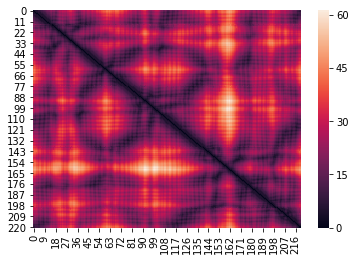

YP_009725306.1.B99990001.pdb


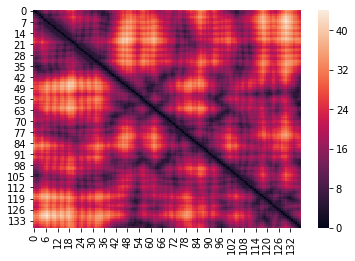

YP_009725307.1.B99990001.pdb


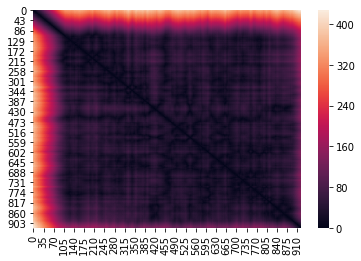

YP_009725311.1.B99990001.pdb


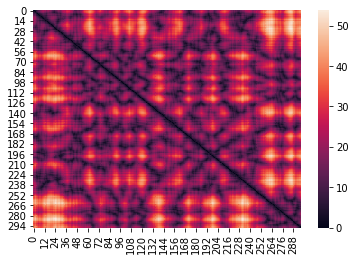

YP_009725308.1.B99990001.pdb


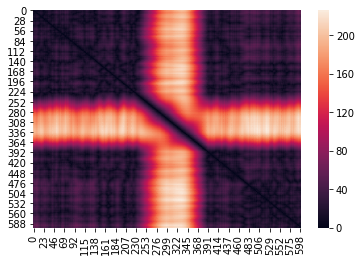

YP_009724395.1.B99990001.pdb


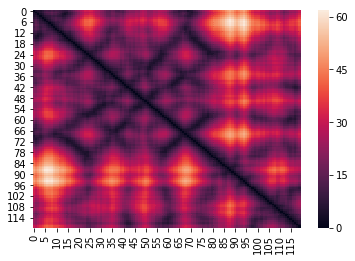

YP_009725302.1.B99990001.pdb


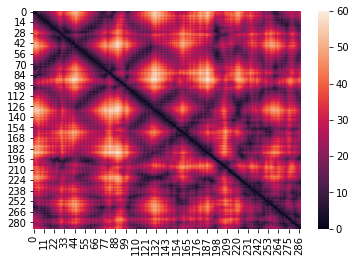

YP_009725298.1.B99990001.pdb


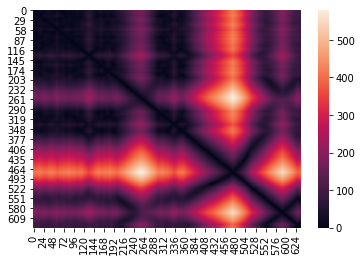

YP_009725305.1.B99990001.pdb


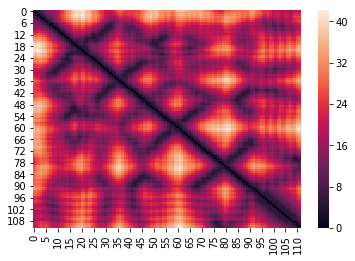

YP_009725301.1.B99990001.pdb


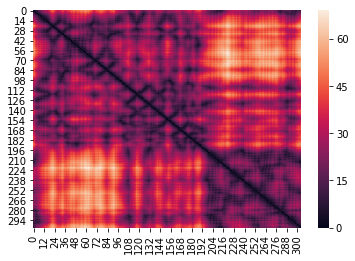

YP_009725309.1.B99990001.pdb


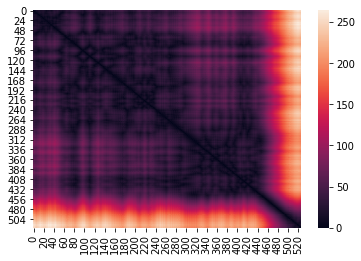

YP_009725300.1.B99990001.pdb


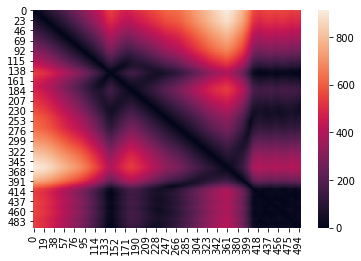

YP_009724397.2.B99990001.pdb


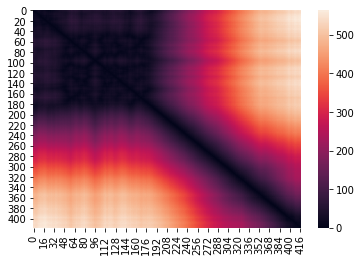

YP_009725299.1.B99990001.pdb


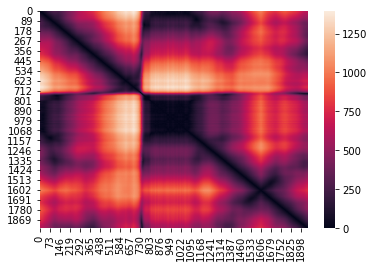

YP_009725304.1.B99990001.pdb


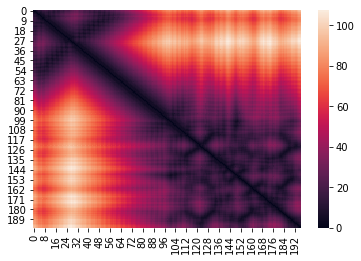

YP_009724390.1.B99990001.pdb


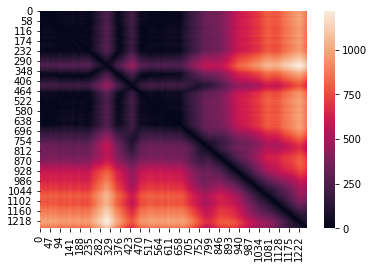

YP_009724394.1.B99990001.pdb


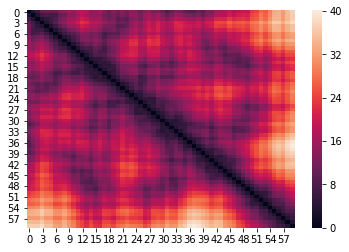

YP_009725310.1.B99990001.pdb


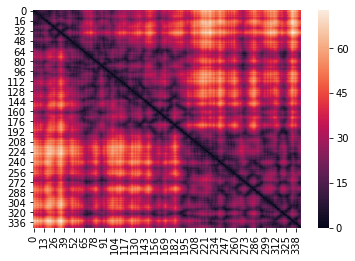

YP_009725303.1.B99990001.pdb


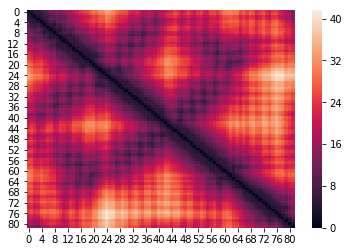

YP_009724396.1.B99990001.pdb


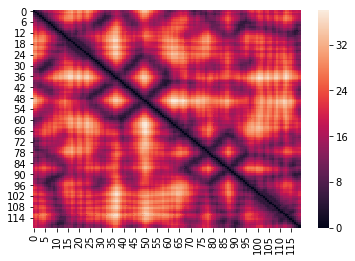

In [11]:
from Bio.PDB.PDBParser import PDBParser
parser = PDBParser()

import seaborn as sns
for m in models:
    print(m)
    structure = parser.get_structure("test", m)
    model = structure[0]
    for chain in model.get_chains():
        distmat = np.array([ [ np.linalg.norm( r1["CA"].get_coord() - r2["CA"].get_coord() ) if i < j else 0 for i,r1 in enumerate(chain)] for j,r2 in enumerate(chain)] )   
        distmat+=distmat.T
        sns.heatmap( distmat )
        plt.show()
#make distmats for structures


In [24]:
import pandas as pd
import pickle
with open( 'annothack.pkl' , 'rb') as annotin:
    cannotation = pickle.loads(annotin.read())
    
#cannotation = pd.read_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06_wclusters.csv')

print(cannotation)

#all clusters 


    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0            3  testgeno  YP_009725299.1  29848  1945    2698   8532       1   
1           11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
2           13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
3           14  testgeno  YP_009725298.1  29848   638     784   2697       1   
4           16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
5           17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
6           18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
7           20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
8           21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
9           22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
10          24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
11          25  testgeno  YP_009724391.1

YP_009724393.1.B99990001.pdb
<class 'dict'>
{4: [47, 76, 153], 45: [14, 15], 59: [196, 197, 199, 200, 202], 84: [1, 7, 8, 9, 10, 11, 12]}
[ 0 84  0  0  0  0  0 84 84 84 84 84 84  0 45 45  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 59 59  0 59 59  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]


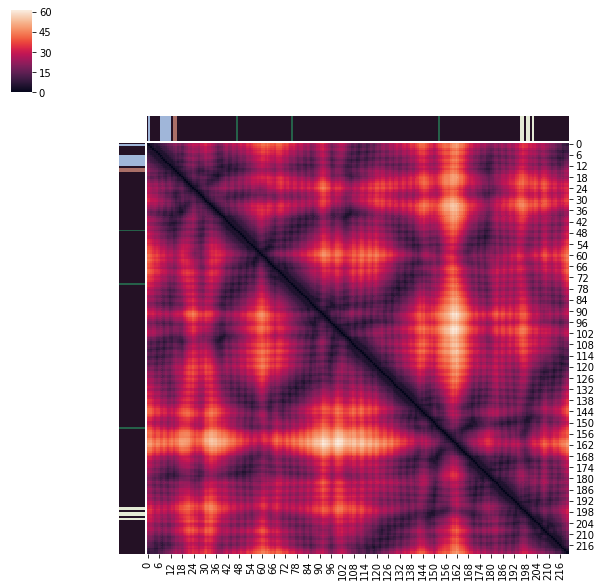

YP_009725306.1.B99990001.pdb
<class 'dict'>
{4: [45]}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


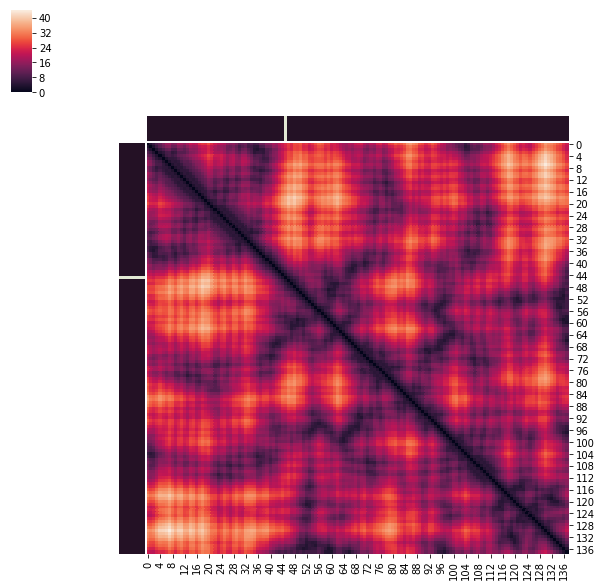

YP_009725307.1.B99990001.pdb
<class 'dict'>
{15: [4, 11, 14, 15, 19, 21, 25, 34, 36, 38, 40, 43, 47], 38: [910, 911, 913, 916, 917, 918, 921], 45: [388], 95: [470]}
[ 0  0  0  0 15  0  0  0  0  0  0 15  0  0 15 15  0  0  0 15  0 15  0  0
  0 15  0  0  0  0  0  0  0  0 15  0 15  0 15  0 15  0  0 15  0  0  0 15
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  

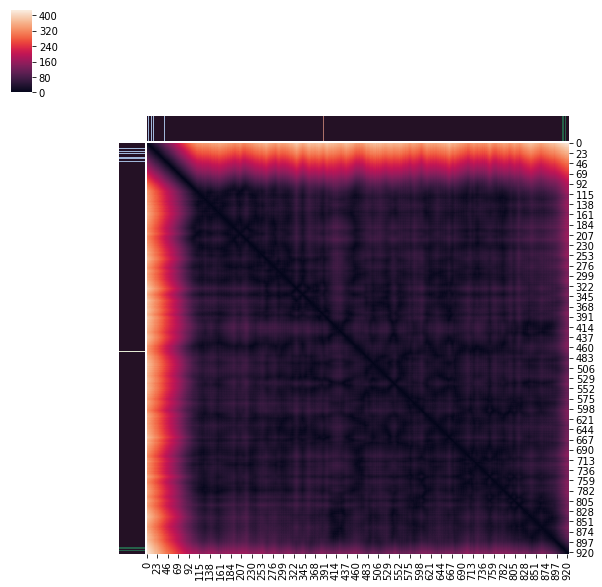

YP_009725311.1.B99990001.pdb
<class 'dict'>
{4: [126], 61: [178, 180, 181, 184, 185, 186, 187, 188, 189, 191, 192, 195, 196, 197, 198, 199, 202, 208, 217, 221, 222, 224, 225, 226, 229, 235, 237, 238, 242, 246, 247, 248, 250]}
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 61  0 61 61  0  0 61 61 61 61 61 61  0 61
 61  0  0 61 61 61 61 61  0  0 61  0  0  0  0  0 61  0  0  0  0  0  0  0
  0 61  0  0  0 61 61  0 61 61 61  0  0 61  0  0  0  0  0 61  0 61 61  0
  0  0 61  0  0  0 61 61 61  0 61  0  0  0  

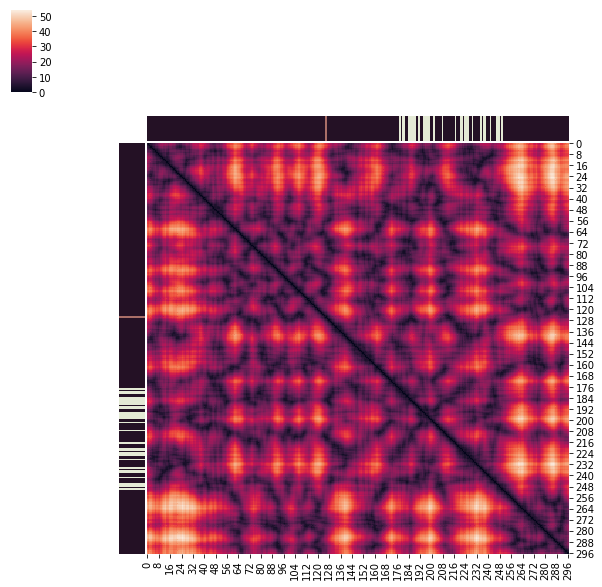

YP_009725308.1.B99990001.pdb
<class 'dict'>
{24: [521, 527, 529, 538, 539, 540, 541, 548, 555, 556, 571, 573, 579], 38: [6, 7, 14], 66: [279]}
[ 0  0  0  0  0  0 38 38  0  0  0  0  0  0 38  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 66  0  0

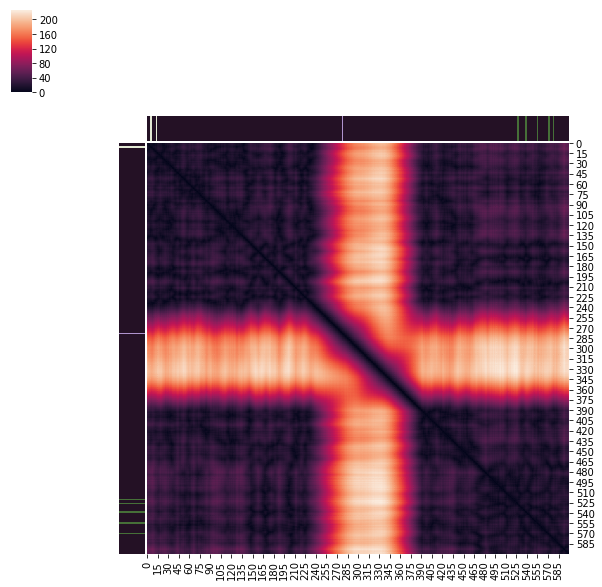

YP_009724395.1.B99990001.pdb
<class 'dict'>
{10: [110, 112, 116, 117], 13: [58, 62, 67, 68, 69, 72, 77, 79, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 100, 102, 103, 105, 106, 108, 109]}
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 13  0  0  0 13  0  0  0  0 13 13 13  0  0
 13  0  0  0  0 13  0 13  0 13  0 13 13  0 13 13 13 13 13 13 13 13  0 13
  0 13  0  0 13  0 13 13  0 13 13  0 13 13 10  0 10  0  0  0 10 10  0  0]


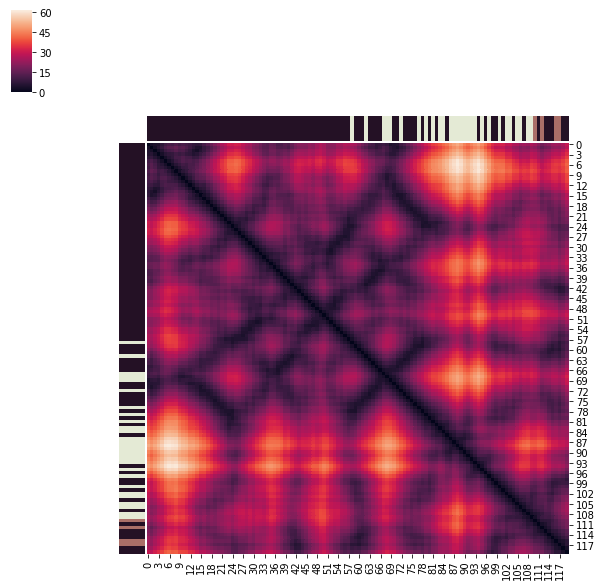

YP_009725302.1.B99990001.pdb
<class 'dict'>
{4: [57], 81: [14], 84: [259, 268, 272, 274, 278, 281, 288]}
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 81  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 84  0  0  0  0
  0  0  0  0 84  0  0  0 84  0 84  0  0  0 84  0  0 84  0  0  0  0  0  0
 84]


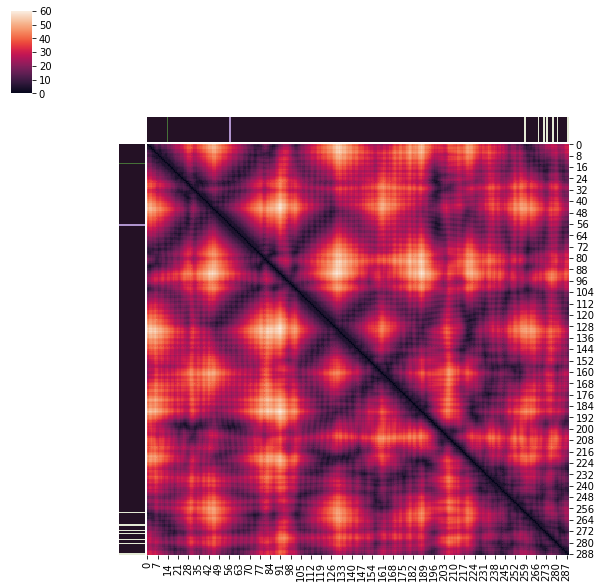

YP_009725298.1.B99990001.pdb
<class 'dict'>
{4: [134, 141, 198], 23: [596, 597, 598, 602, 603, 611], 38: [1], 41: [490, 491, 492, 494, 496, 504, 506, 515, 521, 523, 526, 527, 528, 532, 536, 539, 540, 541, 543, 546, 547, 548, 549, 550, 553, 556, 557, 559, 561, 565, 566, 567, 572, 576], 45: [91], 59: [14, 21, 25, 28], 64: [109, 279, 282, 287, 294, 297, 300, 306, 307, 310, 311, 313, 314, 315, 316, 328, 334, 336, 339, 341, 344, 346, 348, 349, 352, 353, 359, 364, 366]}
[ 0 38  0  0  0  0  0  0  0  0  0  0  0  0 59  0  0  0  0  0  0 59  0  0
  0 59  0  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 45  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 64  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  4  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  

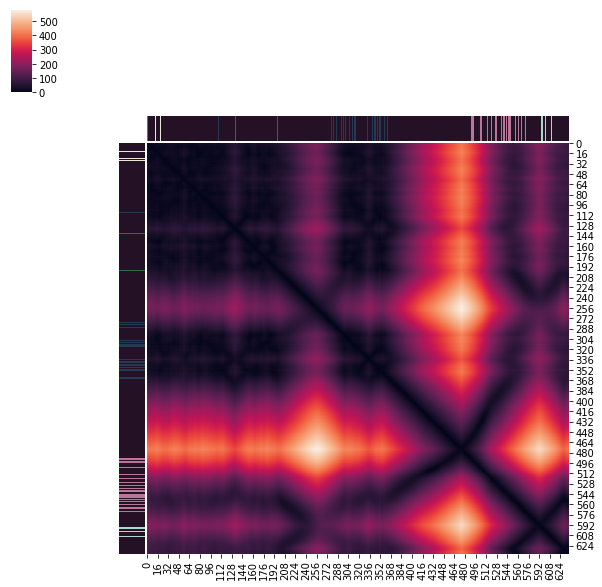

YP_009725305.1.B99990001.pdb
<class 'dict'>
{4: [58], 90: [1], 95: [16]}
[ 0 90  0  0  0  0  0  0  0  0  0  0  0  0  0  0 95  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


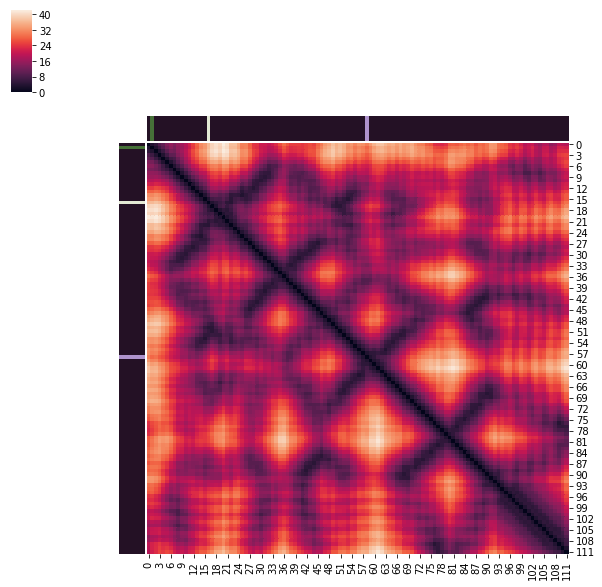

YP_009725301.1.B99990001.pdb
<class 'dict'>
{25: [1, 2, 5, 6, 8], 45: [170, 196, 198, 201, 204, 214], 48: [42, 45, 52, 56, 57, 60, 65, 66, 70, 71, 74, 75, 76, 78, 79, 81, 83, 92, 94, 96, 97, 98, 101, 102, 103, 104, 111, 112, 113, 116]}
[ 0 25 25  0  0 25 25  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 48  0  0 48  0  0
  0  0  0  0 48  0  0  0 48 48  0  0 48  0  0  0  0 48 48  0  0  0 48 48
  0  0 48 48 48  0 48 48  0 48  0 48  0  0  0  0  0  0  0  0 48  0 48  0
 48 48 48  0  0 48 48 48 48  0  0  0  0  0  0 48 48 48  0  0 48  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 45  0 45  0  0 45  0  0 45  0  0  0  0  0  0  0  0  0 45  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 

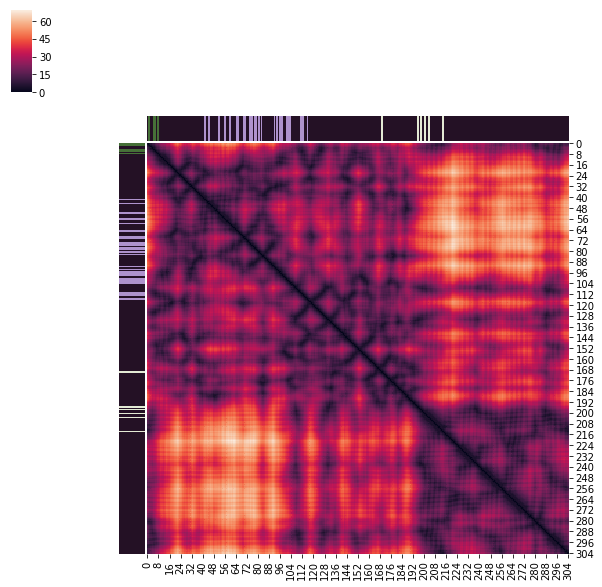

YP_009725309.1.B99990001.pdb
<class 'dict'>
{4: [191], 7: [422, 424, 425, 429, 434, 436, 437, 438, 439, 441, 442, 443, 444, 447, 448, 449, 454, 455, 456, 457, 459, 460, 461, 463, 464, 465, 466, 467, 468, 472, 473, 474, 475, 476, 477, 478, 481, 482, 483, 484, 485, 487, 489, 491, 494, 497, 499, 500, 503, 505, 507, 509], 27: [519, 524], 38: [208, 215, 311, 315], 45: [95, 96, 97], 66: [316, 319, 322, 327, 328, 349, 353, 357, 358, 361, 369, 370, 379, 381, 383, 384, 386, 389, 391], 92: [4, 11, 19, 20, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 37, 47, 48, 50, 54, 63, 68, 78, 79, 81]}
[ 0  0  0  0 92  0  0  0  0  0  0 92  0  0  0  0  0  0  0 92 92  0  0 92
 92  0 92  0 92  0 92 92 92 92 92 92  0 92  0  0  0  0  0  0  0  0  0 92
 92  0 92  0  0  0 92  0  0  0  0  0  0  0  0 92  0  0  0  0 92  0  0  0
  0  0  0  0  0  0 92 92  0 92  0  0  0  0  0  0  0  0  0  0  0  0  0 45
 45 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

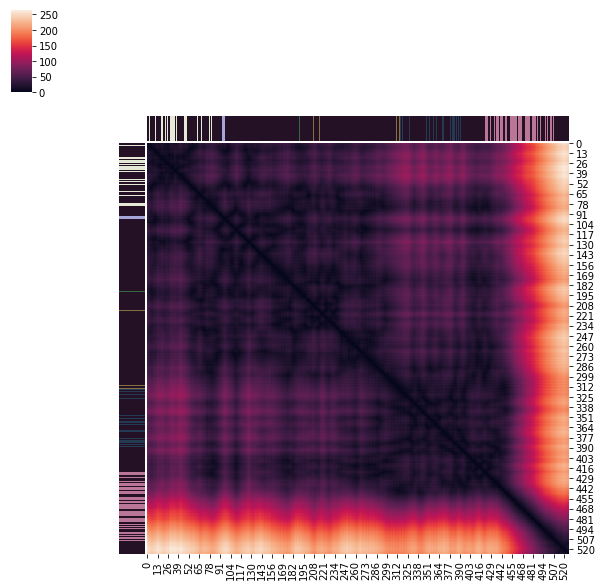

YP_009725300.1.B99990001.pdb
<class 'dict'>
{4: [318], 30: [245, 259, 276, 283, 284, 287, 295, 298, 299, 303, 307, 308, 311, 314, 315], 43: [160, 172, 186, 197, 199, 201, 213, 217, 222, 229, 233], 45: [108], 95: [28]}
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 95  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0
  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0
  0  0  0  0  0 43  0 43  0 43  0  0  0  0  0  0  0  0  0  0  0 43  0  0
  0 43  0  0  0  0 43  0  0  0  0  0  0 43  0  0  0 43  0  0  0  0  0  0
  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0 

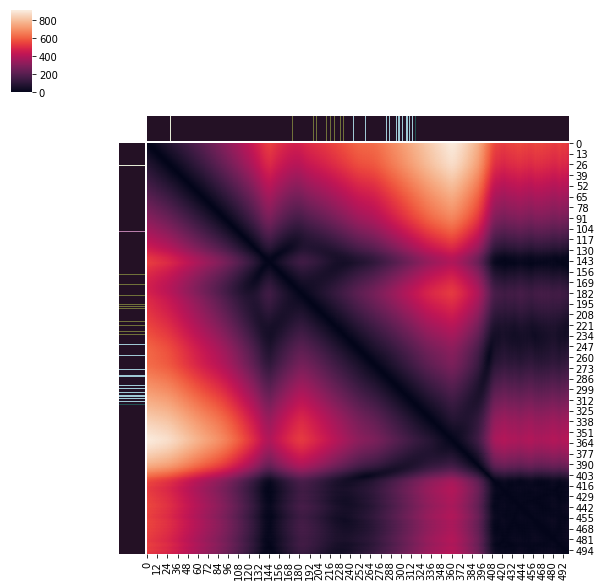

YP_009724397.2.B99990001.pdb
<class 'dict'>
{4: [212], 25: [377, 378, 379, 380, 381, 383, 384, 385, 387, 388, 389, 390, 391, 392, 393, 394, 396, 399, 404, 406, 408, 409], 28: [273, 274, 277, 279, 288, 290, 291, 294, 296, 304, 308, 309, 312, 317, 318, 319, 320, 325, 326, 328, 329, 330, 331, 334, 336, 338, 344, 346, 347, 350], 37: [176, 209, 210, 211, 215, 216, 217, 219, 220, 221, 222, 223, 224, 255, 260, 263], 95: [386, 398, 400]}
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0 

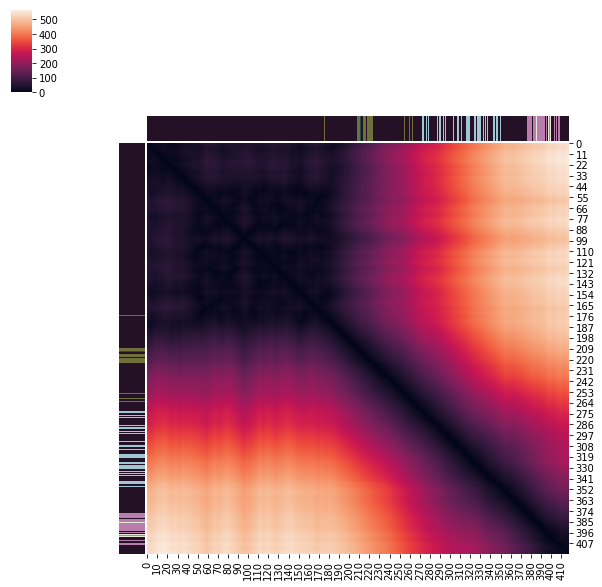

YP_009725299.1.B99990001.pdb
<class 'dict'>
{0: [1091, 1101, 1103, 1104, 1105, 1112, 1113, 1114, 1120, 1124], 4: [170, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182, 189, 191, 192, 194, 195, 197, 199, 201, 203, 216, 217, 224, 228, 230, 232, 235, 236, 241, 242, 249, 1786], 12: [861, 867, 869, 877, 879, 882, 886, 887, 888, 893, 895, 896, 897, 900, 901, 903, 904, 905, 920, 929, 931, 937, 939, 940, 944, 945, 946, 947, 950], 23: [29, 35], 26: [1413], 34: [862, 863, 872, 873, 874, 876, 881, 885, 889, 912, 915, 921, 923, 925, 930, 935, 941, 942, 943, 949, 951, 953], 42: [1652, 1659, 1660, 1672, 1674, 1677, 1692, 1695, 1703, 1705, 1706, 1710, 1715, 1716, 1730, 1731, 1733, 1735, 1738, 1746], 45: [1357, 1366, 1427, 1432, 1435, 1439, 1440, 1600], 80: [772, 773, 774, 780, 781, 1635, 1756, 1760, 1761, 1766, 1768, 1770, 1777, 1794, 1795, 1805, 1808, 1896], 81: [1076, 1077, 1079, 1081, 1084, 1090, 1132, 1134, 1137, 1149, 1412], 87: [1461, 1464, 1466, 1467, 1468, 1469, 1471, 1474, 1476, 1478, 1479,

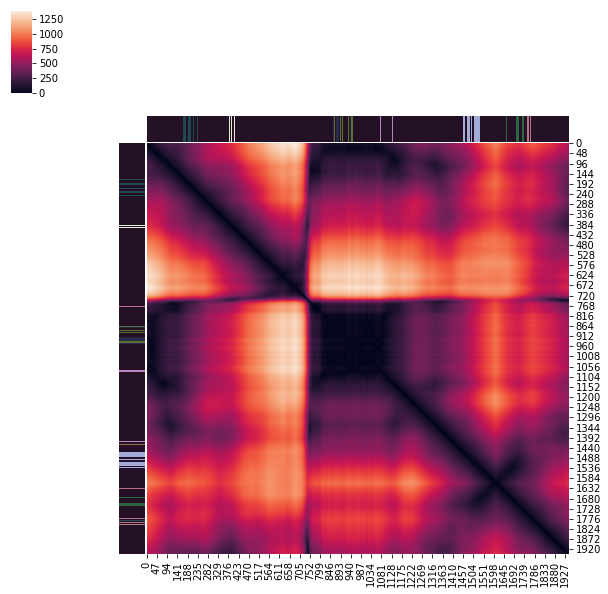

YP_009725304.1.B99990001.pdb
YP_009724390.1.B99990001.pdb
<class 'dict'>
{4: [530, 925, 937], 6: [246, 249, 251, 254, 260, 263, 267, 275, 277, 279, 280, 281, 284, 288, 289, 291, 292, 293, 296, 297, 299, 300, 303, 307, 310], 9: [435, 446, 447, 456, 457, 460, 465, 466, 471, 472, 473, 474, 492, 493, 496, 505, 507, 508, 509, 511], 26: [170, 180, 184, 186, 187, 192], 45: [41, 43, 51, 53, 56, 61, 82, 85, 86, 94, 100, 102, 109, 116, 171, 172], 77: [1154, 1180, 1181, 1197, 1217, 1218, 1219, 1220, 1226, 1232, 1234, 1235]}
[0 0 0 ... 0 0 0]


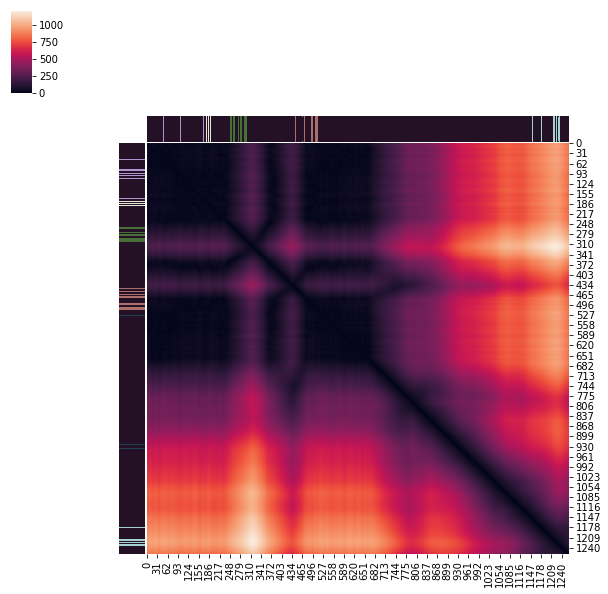

YP_009724394.1.B99990001.pdb
<class 'dict'>
{8: [5, 12, 15, 16, 17, 18], 10: [1, 2, 3, 7, 8, 14]}
[ 0 10 10 10  0  8  0 10 10  0  0  0  8  0 10  8  8  8  8  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


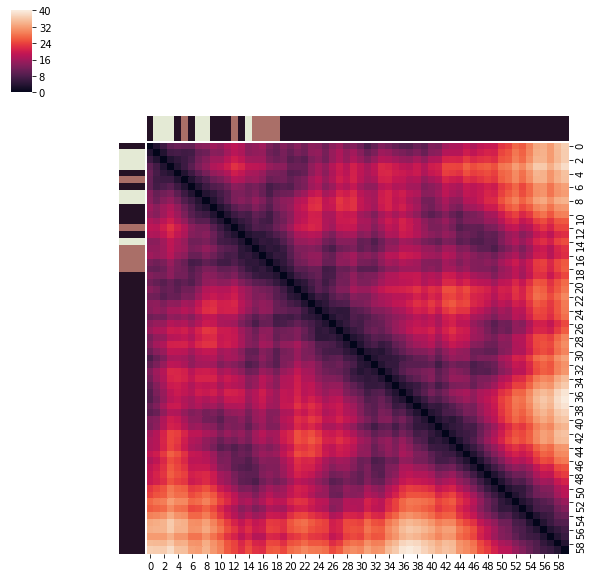

YP_009725310.1.B99990001.pdb
<class 'dict'>
{27: [9, 10, 15, 16, 18, 23, 25, 26, 28, 35, 37, 38, 40, 45, 51, 55], 45: [175, 177]}
[ 0  0  0  0  0  0  0  0  0 27 27  0  0  0  0 27 27  0 27  0  0  0  0 27
  0 27 27  0 27  0  0  0  0  0  0 27  0 27 27  0 27  0  0  0  0 27  0  0
  0  0  0 27  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 45  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

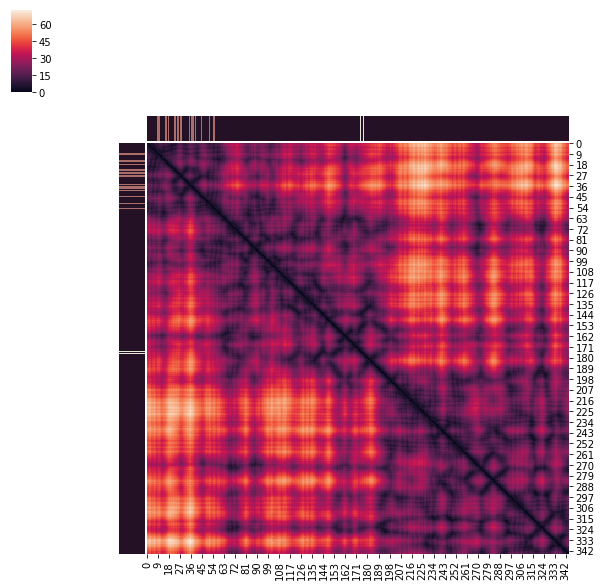

YP_009725303.1.B99990001.pdb
<class 'dict'>
{4: [69], 84: [22, 24, 26]}
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 84  0
 84  0 84  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
  0  0  0  0  0  0  0  0  0  0]


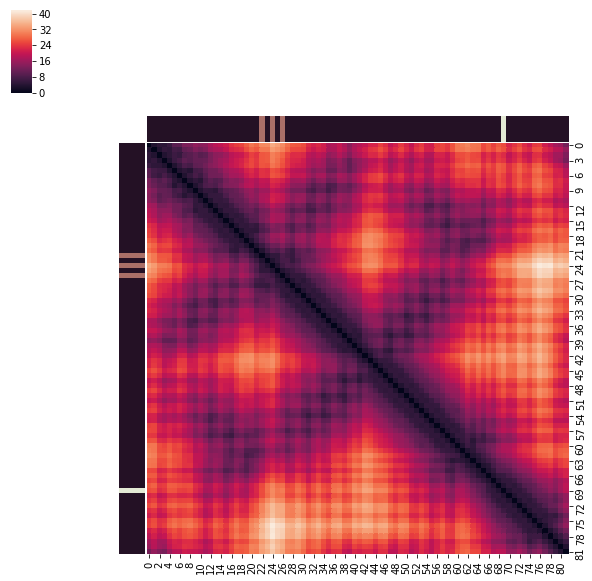

YP_009724396.1.B99990001.pdb
<class 'dict'>
{4: [28], 15: [1, 2, 5, 6, 7, 10], 90: [23, 34, 47, 49, 50, 51, 54, 60, 63, 64, 65, 66, 69, 77, 80, 81, 90]}
[ 0 15 15  0  0 15 15 15  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0 90
  0  0  0  0  4  0  0  0  0  0 90  0  0  0  0  0  0  0  0  0  0  0  0 90
  0 90 90 90  0  0 90  0  0  0  0  0 90  0  0 90 90 90 90  0  0 90  0  0
  0  0  0  0  0 90  0  0 90 90  0  0  0  0  0  0  0  0 90  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


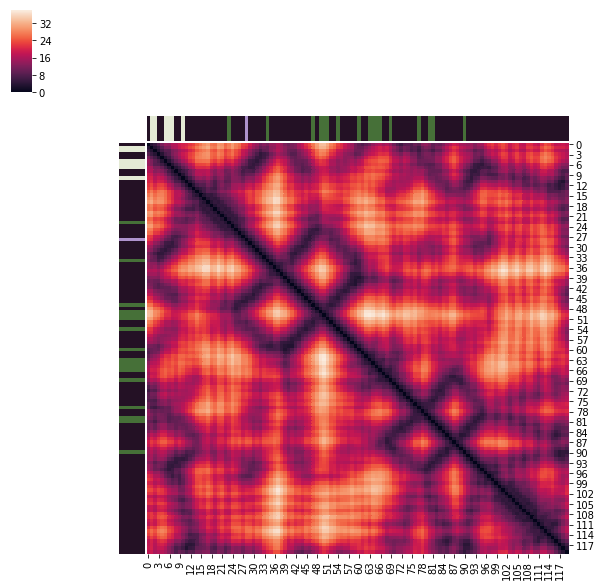

In [50]:
#use the 

from Bio.PDB.PDBParser import PDBParser
parser = PDBParser()
import json 
import seaborn as sns
with open( 'crange.pkl' , 'rb' ) as crangein:
    crange= pickle.loads(crangein.read())

for m in models:
    print(m)
    structure = parser.get_structure("test", m)
    model = structure[0]
    for chain in model.get_chains():
        distmat = np.array([ [ np.linalg.norm( r1["CA"].get_coord() - r2["CA"].get_coord() ) if i < j else 0 for i,r1 in enumerate(chain)] for j,r2 in enumerate(chain)] )   
        distmat+=distmat.T
        annotations = None
        
        for i,r in cannotation.iterrows():
            
            if r.sseqid in m:
                try:
                    annotations = dict( r.clusters  )

                    print(type(annotations))
                    # white or cluster color
                except:
                    pass
                break
                
        if annotations:     
            #go over all positions 
            print(annotations)
            colorvec = np.zeros((distmat.shape[0],) , dtype = np.int)
            count = 1
            for l in annotations:
                colorvec[annotations[l]]= l
            print(colorvec)
            colorvec = list(colorvec.ravel())
            network_pal = sns.cubehelix_palette( len(set(colorvec)) , light=.9, dark=.1, reverse=True, start=1, rot=-2) 
            network_lut = dict(zip(set(colorvec), network_pal))

            colorvec = [ network_lut[c] for c in colorvec ]
            g = sns.clustermap( distmat , row_cluster=False, col_cluster=False,row_colors=colorvec, col_colors=colorvec, linewidths=0 )



            plt.show()
            


In [ ]:
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')

crange = [ c.get_hex_l() for c in red.range_to(blue, len(np.unique(cluster_labelsb))) ]
print(crange)